In [ ]:
import pandas as pd
import statistics

import plotly.tools
import scipy.special
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta
import mysql.connector
import pandas.io.sql as sqlio
from sklearn.cluster import KMeans
from sklearn import preprocessing
import sklearn.cluster as cluster
import sklearn.metrics as metrics
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import statistics
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
from xgboost import plot_tree
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
import plotly.express as px
from matplotlib import font_manager
my_font = str(font_manager.FontProperties(fname='/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'))


ModuleNotFoundError: No module named 'mpl_toolkits.basemap'

# Data Preprocessing

In [194]:
# Connect to mysql database
cnx = mysql.connector.connect(user='root', password='Kh18riku!',
                                host='127.0.0.1',
                                database='global_n2o')
cursor = cnx.cursor()

query = ("SELECT * FROM RawClassificationTreatment")
# Execute the query and fetch all results
alldata = pd.read_sql(query, cnx)
cnx.close()

# Drop rows where 'ExperimentID' is 56 or 38 (corrupted data)
alldata = alldata[alldata['ExperimentID'] != 56]
alldata = alldata[alldata['ExperimentID'] != 38]

         
print(alldata['ExperimentID'].unique())

/home/ryan/.virtualenv/time/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



[ 1  2  3  4  5  6  8  9 10 11 12 13 14 22 23 24 25 26 27 28 29 30 31 32
 33 34 35 36 37 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 57 58]


In [195]:
# Merge the columns VWC and VWCcalculated
# print the count of WFPS
alldata['VWC'].fillna(alldata['VWCcalculated'], inplace=True)
alldata['WFPS'].fillna(alldata['WFPScalculated'], inplace=True)
# Drop the calculated columns
alldata = alldata.drop('VWCcalculated', axis=1)
alldata = alldata.drop('WFPScalculated', axis=1)
# If VWC > 1, divide by 100
alldata['VWC'] = alldata['VWC'].apply(lambda x: x / 100 if x > 1 else x)
# Create a Year column by converting the Date column to datetime
alldata['Year'] = pd.to_datetime(alldata['Date']).dt.year

# Create a Group column by concatenating ExperimentID and Year
alldata['Group'] = alldata['ExperimentID'].astype(str) + '_' + alldata['Year'].astype(str)
print(alldata.count())


RawID                207232
PubID                207232
ExperimentID         207232
TreatmentID          207232
Date                 207232
DOY                  207232
N2OFlux               22954
FluxStandardError      9280
HMTruth              148856
HMMCD                203503
HMMAD                 22936
HMKNN                 22482
HMIQR                 22936
VWC                   15774
WFPS                  10135
SoilT                 17899
AirT                  19688
Precip               200191
NitrogenApplied      206353
NitrogenType            519
AirTMax              160847
AirTMin              160557
PrimaryCrop          207232
Management           207232
SandMean             203807
SiltMean             203807
ClayMean             203807
Gracenet             207232
MAP                  203078
MAT                  203078
Latitude             207232
Longitude            207232
PubTitle             207232
Citation             207232
Year                 207232
Group               

In [196]:
# Linear Interpolate the VWC and SoilT and AirT columns for each TreatmentID as long as measurement
# gaps are less than 14 days. If the measurement gap is greater than 14 days, then set VWC and
# SoilT to None
import math
alldata['VWC'] = alldata['VWC'].astype(float)
alldata['SoilT'] = alldata['SoilT'].astype(float)
alldata['AirT'] = alldata['AirT'].astype(float)
alldata['WFPS'] = alldata['WFPS'].astype(float)
# Create separate interpolated columns for VWC, SoilT, and AirT
alldata['VWC_interpolated'] = alldata['VWC']
alldata['SoilT_interpolated'] = alldata['SoilT']
alldata['AirT_interpolated'] = alldata['AirT']
alldata['WFPS_interpolated'] = alldata['WFPS']
alldata['VWC_days_since_last_measurement'] = None
alldata['VWC_days_until_next_measurement'] = None


# Iterate through each TreatmentID and interpolate the VWC, SoilT, and AirT columns
for treatment in alldata['TreatmentID'].unique():
    treatment_df = alldata[alldata['TreatmentID'] == treatment]
    treatment_df['VWC_interpolated'] = treatment_df['VWC_interpolated'].interpolate(limit_direction='both', limit=7, limit_area='inside')
    treatment_df['SoilT_interpolated'] = treatment_df['SoilT_interpolated'].interpolate(limit_direction='both', limit=7, limit_area='inside')
    treatment_df['AirT_interpolated'] = treatment_df['AirT_interpolated'].interpolate(limit_direction='both', limit=7, limit_area='inside')
    treatment_df['WFPS_interpolated'] = treatment_df['WFPS_interpolated'].interpolate(limit_direction='both', limit=7, limit_area='inside')
    # Iterate through each row and calculate the number of days since the last row where VWC was not None
    i = 0
    for index, row in treatment_df.iterrows():
        # If vwc is nan, set it to None
        if row['VWC'] == '' or row['VWC'] == None or math.isnan(row['VWC']):
            i += 1
            treatment_df.at[index, 'VWC_days_since_last_measurement'] = i
        else:
            i = 0
            treatment_df.at[index, 'VWC_days_since_last_measurement'] = i
    
    # Iterate through each row and calculate the number of days until the next row where VWC was not None
    i = 0
    # Start by iterating through rows in reverse
    # reverse the rows of the treatment_df
    treatment_df = treatment_df.iloc[::-1]
    for index, row in treatment_df.iterrows():
        if row['VWC'] == '' or row['VWC'] == None or math.isnan(row['VWC']):
            i += 1
            treatment_df.at[index, 'VWC_days_until_next_measurement'] = i
        else:
            i = 0
            treatment_df.at[index, 'VWC_days_until_next_measurement'] = i
    
    # reverse the rows of the treatment_df
    treatment_df = treatment_df.iloc[::-1]
    alldata[alldata['TreatmentID'] == treatment] = treatment_df

alldata['VWC'] = alldata['VWC_interpolated']
alldata['WFPS'] = alldata['WFPS_interpolated']
alldata['SoilT'] = alldata['SoilT_interpolated']
alldata['AirT'] = alldata['AirT_interpolated']
alldata['VWC_days_since_last_measurement'] = alldata['VWC_days_since_last_measurement'].astype(int)
alldata['VWC_days_until_next_measurement'] = alldata['VWC_days_until_next_measurement'].astype(int)
alldata = alldata.drop('VWC_interpolated', axis=1)
alldata = alldata.drop('WFPS_interpolated', axis=1)
alldata = alldata.drop('SoilT_interpolated', axis=1)
alldata = alldata.drop('AirT_interpolated', axis=1)

print(alldata.count())
# Save to csv
alldata.to_csv('alldata_tracker.csv', index=False)


/tmp/ipykernel_4306/245788343.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_4306/245788343.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_4306/245788343.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_4306

RawID                              207232
PubID                              207232
ExperimentID                       207232
TreatmentID                        207232
Date                               207232
DOY                                207232
N2OFlux                             22954
FluxStandardError                    9280
HMTruth                            148856
HMMCD                              203503
HMMAD                               22936
HMKNN                               22482
HMIQR                               22936
VWC                                 95386
WFPS                                53804
SoilT                              103859
AirT                                76665
Precip                             200191
NitrogenApplied                    206353
NitrogenType                          519
AirTMax                            160847
AirTMin                            160557
PrimaryCrop                        207232
Management                        

In [197]:
experiments = pd.unique(alldata.TreatmentID)
alldata['days_since_precip'] = 0
alldata['last_precip'] = None
days_since_p_list = []
last_p_list = []
for experiment in experiments:
    expdf = alldata.query('TreatmentID == @experiment')
    first_flag = 1
    print(experiment)
    for index, row in expdf.iterrows():
        if row['Precip'] > 0:
            expdf.loc[index, "days_since_precip"] = 0
            expdf.loc[index, "last_precip"] = row['Precip']
            last_precip = row['Precip']
        elif first_flag == 1:
            expdf.loc[index, "days_since_precip"] = None
        elif past_days == None:
            expdf.loc[index, "days_since_precip"] = None
        elif row.Precip == 0:
            expdf.loc[index, "days_since_precip"] = past_days + 1
            expdf.loc[index, "last_precip"] = last_precip
        past_days = expdf.loc[index, "days_since_precip"]
        first_flag = 0  
    days_since_p_list.extend(list(expdf.days_since_precip))
    last_p_list.extend(list(expdf.last_precip))
alldata['days_since_precip'] = days_since_p_list
alldata['last_precip'] = last_p_list

2
3
4


/tmp/ipykernel_4306/1664451900.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
137
138
139
140
141
142
143
144
145
146
147
149
150
151
152
153
154
155
156
157
158
159
160
161
162
164
166
167
169
170
171
180
181
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
270
273
276
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
302
303
305
306
307
308
309
310
311
312
313
314
315
316
317
330
331
332
318
319
333
334
320
321
322
323
324
326
327
328
329


In [198]:
print(alldata.head())

   RawID  PubID  ExperimentID  TreatmentID        Date  DOY   N2OFlux  \
0      1      1             1            2  2006-06-19  170  -9.69777   
1      2      1             1            2  2006-06-20  171  43.61360   
2      3      1             1            2  2006-06-21  172  -4.27172   
3      4      1             1            2  2006-06-22  173  53.78540   
4      5      1             1            2  2006-06-23  174  23.54990   

   FluxStandardError  HMTruth  HMMCD  ... Latitude  Longitude  \
0                NaN      0.0    0.0  ...  42.4261   -76.2267   
1                NaN      0.0    0.0  ...  42.4261   -76.2267   
2                NaN      0.0    0.0  ...  42.4261   -76.2267   
3                NaN      0.0    0.0  ...  42.4261   -76.2267   
4                NaN      0.0    0.0  ...  42.4261   -76.2267   

                                            PubTitle  \
0  Temporal variability of nitrous oxide from fer...   
1  Temporal variability of nitrous oxide from fer...   
2 

In [199]:
experiments = pd.unique(alldata.TreatmentID)
alldata['days_since_fert'] = 0
alldata['last_fert'] = None
alldata['last_fert_type'] = None
days_since_f_list = []
last_f_list = []
last_type_list = []
for experiment in experiments:
    expdf = alldata.query('TreatmentID == @experiment')
    first_flag = 1
    print(experiment)
    for index, row in expdf.iterrows():
        if row['NitrogenApplied'] > 0:
            expdf.loc[index, "days_since_fert"] = 0
            expdf.loc[index, "last_fert"] = row['NitrogenApplied']
            expdf.loc[index, "last_fert_type"] = row['NitrogenType']
            last_fert = row['NitrogenApplied']
            last_fert_type = row['NitrogenType']
        elif first_flag == 1:
            expdf.loc[index, "days_since_fert"] = None
        elif past_days == None:
            expdf.loc[index, "days_since_fert"] = None
        elif row.NitrogenApplied == 0:
            expdf.loc[index, "days_since_fert"] = past_days + 1
            expdf.loc[index, "last_fert"] = last_fert
            expdf.loc[index, "last_fert_type"] = last_fert_type
            
        past_days = expdf.loc[index, "days_since_fert"]
        first_flag = 0  
    days_since_f_list.extend(list(expdf.days_since_fert))
    last_f_list.extend(list(expdf.last_fert))
    last_type_list.extend(list(expdf.last_fert_type))
alldata['days_since_fert'] = days_since_f_list
alldata['last_fert'] = last_f_list
alldata['last_fert_type'] = last_type_list

2
3
4
5


/tmp/ipykernel_4306/644663200.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6
7
8
9
10
11
12
13
14
15
16
17
18
19
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
137
138
139
140
141
142
143
144
145
146
147
149
150
151
152
153
154
155
156
157
158
159
160
161
162
164
166
167
169
170
171
180
181
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
270
273
276
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
302
303
305
306
307
308
309
310
311
312
313
314
315
316
317
330
331
332
318
319
333
334
320
321
322
323
324
326
327
328
329


In [200]:
experiments = pd.unique(alldata.TreatmentID)
alldata['airT_dm1'] = None
alldata['airT_dm2'] = None
alldata['airT_dm3'] = None
alldata['airT_dm4'] = None
alldata['airT_dm5'] = None
alldata['airT_dm6'] = None
alldata['airT_dm7'] = None
alldata['vwc_dm1'] = None
alldata['vwc_dm2'] = None
alldata['vwc_dm3'] = None
alldata['vwc_dm4'] = None
alldata['vwc_dm5'] = None
alldata['vwc_dm6'] = None
alldata['vwc_dm7'] = None
alldata['wfps_dm1'] = None
alldata['wfps_dm2'] = None
alldata['wfps_dm3'] = None
alldata['wfps_dm4'] = None
alldata['wfps_dm5'] = None
alldata['wfps_dm6'] = None
alldata['wfps_dm7'] = None
alldata['precip_dm1'] = None
alldata['precip_dm2'] = None
alldata['precip_dm3'] = None
alldata['precip_dm4'] = None
alldata['precip_dm5'] = None
alldata['precip_dm6'] = None
alldata['precip_dm7'] = None
alldata['soilT_dm1'] = None
alldata['soilT_dm2'] = None
alldata['soilT_dm3'] = None
alldata['soilT_dm4'] = None
alldata['soilT_dm5'] = None
alldata['soilT_dm6'] = None
alldata['soilT_dm7'] = None

airt1 = []
airt2 = []
airt3 = []
airt4 = []
airt5 = []
airt6 = []
airt7 = []
vwc1 = []
vwc2 = []
vwc3 = []
vwc4 = []
vwc5 = []
vwc6 = []
vwc7 = []
wfps1 = []
wfps2 = []
wfps3 = []
wfps4 = []
wfps5 = []
wfps6 = []
wfps7 = []
precip1 = []
precip2 = []
precip3 = []
precip4 = []
precip5 = []
precip6 = []
precip7 = []
soilt1 = []
soilt2 = []
soilt3 = []
soilt4 = []
soilt5 = []
soilt6 = []
soilt7 = []

for experiment in experiments:
    expdf = alldata.query('TreatmentID == @experiment')
    expdf.reset_index(drop=True, inplace=True)
    day_count = 1
    for index, row in expdf.iterrows():
        if day_count < 8:
            day_count += 1
            continue
        expdf.loc[index, "airT_dm1"] = expdf.loc[index - 1, "AirT"]
        expdf.loc[index, "airT_dm2"] = expdf.loc[index - 2, "AirT"]
        expdf.loc[index, "airT_dm3"] = expdf.loc[index - 3, "AirT"]
        expdf.loc[index, "airT_dm4"] = expdf.loc[index - 4, "AirT"]
        expdf.loc[index, "airT_dm5"] = expdf.loc[index - 5, "AirT"]
        expdf.loc[index, "airT_dm6"] = expdf.loc[index - 6, "AirT"]
        expdf.loc[index, "airT_dm7"] = expdf.loc[index - 7, "AirT"]
        
        expdf.loc[index, "vwc_dm1"] = expdf.loc[index - 1, "VWC"]
        expdf.loc[index, "vwc_dm2"] = expdf.loc[index - 2, "VWC"]
        expdf.loc[index, "vwc_dm3"] = expdf.loc[index - 3, "VWC"]
        expdf.loc[index, "vwc_dm4"] = expdf.loc[index - 4, "VWC"]
        expdf.loc[index, "vwc_dm5"] = expdf.loc[index - 5, "VWC"]
        expdf.loc[index, "vwc_dm6"] = expdf.loc[index - 6, "VWC"]
        expdf.loc[index, "vwc_dm7"] = expdf.loc[index - 7, "VWC"]

        expdf.loc[index, "wfps_dm1"] = expdf.loc[index - 1, "WFPS"]
        expdf.loc[index, "wfps_dm2"] = expdf.loc[index - 2, "WFPS"]
        expdf.loc[index, "wfps_dm3"] = expdf.loc[index - 3, "WFPS"]
        expdf.loc[index, "wfps_dm4"] = expdf.loc[index - 4, "WFPS"]
        expdf.loc[index, "wfps_dm5"] = expdf.loc[index - 5, "WFPS"]
        expdf.loc[index, "wfps_dm6"] = expdf.loc[index - 6, "WFPS"]
        expdf.loc[index, "wfps_dm7"] = expdf.loc[index - 7, "WFPS"]
        
        expdf.loc[index, "precip_dm1"] = expdf.loc[index - 1, "Precip"]
        expdf.loc[index, "precip_dm2"] = expdf.loc[index - 2, "Precip"]
        expdf.loc[index, "precip_dm3"] = expdf.loc[index - 3, "Precip"]
        expdf.loc[index, "precip_dm4"] = expdf.loc[index - 4, "Precip"]
        expdf.loc[index, "precip_dm5"] = expdf.loc[index - 5, "Precip"]
        expdf.loc[index, "precip_dm6"] = expdf.loc[index - 6, "Precip"]
        expdf.loc[index, "precip_dm7"] = expdf.loc[index - 7, "Precip"]
        
        expdf.loc[index, "soilT_dm1"] = expdf.loc[index - 1, "SoilT"]
        expdf.loc[index, "soilT_dm2"] = expdf.loc[index - 2, "SoilT"]
        expdf.loc[index, "soilT_dm3"] = expdf.loc[index - 3, "SoilT"]
        expdf.loc[index, "soilT_dm4"] = expdf.loc[index - 4, "SoilT"]
        expdf.loc[index, "soilT_dm5"] = expdf.loc[index - 5, "SoilT"]
        expdf.loc[index, "soilT_dm6"] = expdf.loc[index - 6, "SoilT"]
        expdf.loc[index, "soilT_dm7"] = expdf.loc[index - 7, "SoilT"]
        
        day_count += 1
    airt1.extend(list(expdf.airT_dm1))
    airt2.extend(list(expdf.airT_dm2))
    airt3.extend(list(expdf.airT_dm3))
    airt4.extend(list(expdf.airT_dm4))
    airt5.extend(list(expdf.airT_dm5))
    airt6.extend(list(expdf.airT_dm6))
    airt7.extend(list(expdf.airT_dm7))
    vwc1.extend(list(expdf.vwc_dm1))
    vwc2.extend(list(expdf.vwc_dm2))
    vwc3.extend(list(expdf.vwc_dm3))
    vwc4.extend(list(expdf.vwc_dm4))
    vwc5.extend(list(expdf.vwc_dm5))
    vwc6.extend(list(expdf.vwc_dm6))
    vwc7.extend(list(expdf.vwc_dm7))
    wfps1.extend(list(expdf.wfps_dm1))
    wfps2.extend(list(expdf.wfps_dm2))
    wfps3.extend(list(expdf.wfps_dm3))
    wfps4.extend(list(expdf.wfps_dm4))
    wfps5.extend(list(expdf.wfps_dm5))
    wfps6.extend(list(expdf.wfps_dm6))
    wfps7.extend(list(expdf.wfps_dm7))
    precip1.extend(list(expdf.precip_dm1))
    precip2.extend(list(expdf.precip_dm2))
    precip3.extend(list(expdf.precip_dm3))
    precip4.extend(list(expdf.precip_dm4))
    precip5.extend(list(expdf.precip_dm5))
    precip6.extend(list(expdf.precip_dm6))
    precip7.extend(list(expdf.precip_dm7))
    soilt1.extend(list(expdf.soilT_dm1))
    soilt2.extend(list(expdf.soilT_dm2))
    soilt3.extend(list(expdf.soilT_dm3))
    soilt4.extend(list(expdf.soilT_dm4))
    soilt5.extend(list(expdf.soilT_dm5))
    soilt6.extend(list(expdf.soilT_dm6))
    soilt7.extend(list(expdf.soilT_dm7))
    
alldata['airT_dm1'] = airt1
alldata['airT_dm2'] = airt2
alldata['airT_dm3'] = airt3
alldata['airT_dm4'] = airt4
alldata['airT_dm5'] = airt5
alldata['airT_dm6'] = airt6
alldata['airT_dm7'] = airt7
alldata['vwc_dm1'] = vwc1
alldata['vwc_dm2'] = vwc2
alldata['vwc_dm3'] = vwc3
alldata['vwc_dm4'] = vwc4
alldata['vwc_dm5'] = vwc5
alldata['vwc_dm6'] = vwc6
alldata['vwc_dm7'] = vwc7
alldata['wfps_dm1'] = wfps1
alldata['wfps_dm2'] = wfps2
alldata['wfps_dm3'] = wfps3
alldata['wfps_dm4'] = wfps4
alldata['wfps_dm5'] = wfps5
alldata['wfps_dm6'] = wfps6
alldata['wfps_dm7'] = wfps7
alldata['precip_dm1'] = precip1
alldata['precip_dm2'] = precip2
alldata['precip_dm3'] = precip3
alldata['precip_dm4'] = precip4
alldata['precip_dm5'] = precip5
alldata['precip_dm6'] = precip6
alldata['precip_dm7'] = precip7
alldata['soilT_dm1'] = soilt1
alldata['soilT_dm2'] = soilt2
alldata['soilT_dm3'] = soilt3
alldata['soilT_dm4'] = soilt4
alldata['soilT_dm5'] = soilt5
alldata['soilT_dm6'] = soilt6
alldata['soilT_dm7'] = soilt7

In [201]:
# Create a rolling mean for VWC, AirT, SoilT, and WFPS
alldata['VWC_rollingmean'] = alldata['VWC'].rolling(window=3).mean()
alldata['WFPS_rollingmean'] = alldata['WFPS'].rolling(window=3).mean()
alldata['AirT_rollingmean'] = alldata['AirT'].rolling(window=3).mean()
alldata['SoilT_rollingmean'] = alldata['SoilT'].rolling(window=3).mean()


In [202]:
print(alldata.head())

   RawID  PubID  ExperimentID  TreatmentID        Date  DOY   N2OFlux  \
0      1      1             1            2  2006-06-19  170  -9.69777   
1      2      1             1            2  2006-06-20  171  43.61360   
2      3      1             1            2  2006-06-21  172  -4.27172   
3      4      1             1            2  2006-06-22  173  53.78540   
4      5      1             1            2  2006-06-23  174  23.54990   

   FluxStandardError  HMTruth  HMMCD  ... soilT_dm2  soilT_dm3  soilT_dm4  \
0                NaN      0.0    0.0  ...       NaN        NaN        NaN   
1                NaN      0.0    0.0  ...       NaN        NaN        NaN   
2                NaN      0.0    0.0  ...       NaN        NaN        NaN   
3                NaN      0.0    0.0  ...       NaN        NaN        NaN   
4                NaN      0.0    0.0  ...       NaN        NaN        NaN   

   soilT_dm5  soilT_dm6  soilT_dm7  VWC_rollingmean  WFPS_rollingmean  \
0        NaN        NaN  

In [203]:
# Drop all rows where N2OFlux is NaN
#alldata = alldata.dropna(subset=['N2OFlux'])
alldata.to_csv("classification_data_ts-YEAR_SEPARATED.csv", index=False)

In [273]:
alldata = pd.read_csv("classification_data_ts-YEAR_SEPARATED.csv")
print((alldata.columns))
# drop columns where N2Oflux is none
alldata = alldata.dropna(subset=['N2OFlux'])

Index(['RawID', 'PubID', 'ExperimentID', 'TreatmentID', 'Date', 'DOY',
       'N2OFlux', 'FluxStandardError', 'HMTruth', 'HMMCD', 'HMMAD', 'HMKNN',
       'HMIQR', 'VWC', 'WFPS', 'SoilT', 'AirT', 'Precip', 'NitrogenApplied',
       'NitrogenType', 'AirTMax', 'AirTMin', 'PrimaryCrop', 'Management',
       'SandMean', 'SiltMean', 'ClayMean', 'Gracenet', 'MAP', 'MAT',
       'Latitude', 'Longitude', 'PubTitle', 'Citation', 'Year', 'Group',
       'VWC_days_since_last_measurement', 'VWC_days_until_next_measurement',
       'days_since_precip', 'last_precip', 'days_since_fert', 'last_fert',
       'last_fert_type', 'airT_dm1', 'airT_dm2', 'airT_dm3', 'airT_dm4',
       'airT_dm5', 'airT_dm6', 'airT_dm7', 'vwc_dm1', 'vwc_dm2', 'vwc_dm3',
       'vwc_dm4', 'vwc_dm5', 'vwc_dm6', 'vwc_dm7', 'wfps_dm1', 'wfps_dm2',
       'wfps_dm3', 'wfps_dm4', 'wfps_dm5', 'wfps_dm6', 'wfps_dm7',
       'precip_dm1', 'precip_dm2', 'precip_dm3', 'precip_dm4', 'precip_dm5',
       'precip_dm6', 'precip_dm7', 'soi

In [274]:
dropdata = alldata.drop(['WFPS', 'NitrogenType', 'FluxStandardError', 'AirTMax', 'AirTMin', 'AirT', 'Gracenet', 'PubID', 'HMKNN',
                        'airT_dm1', 'airT_dm2', 'airT_dm3', 'airT_dm4', 'airT_dm5', 'airT_dm6', 'airT_dm7', 'HMKNN',
                         'wfps_dm1', 'wfps_dm2', 'wfps_dm3', 'wfps_dm4', 'wfps_dm5', 'wfps_dm6', 'wfps_dm7', 'WFPS_rollingmean', 'AirT_rollingmean',
                         ], axis = 1)
dropdata = dropdata.dropna(axis = 0, how ='any', inplace=False)
print(len(dropdata.index))
alldata = dropdata

6626


In [275]:
# For each row, identify the days_since_last_vwc and days_until_next_vwc
days_since = list(alldata['VWC_days_since_last_measurement'])
days_until = list(alldata['VWC_days_until_next_measurement'])
# Sum the days since and days until to get the total gap length
gap_length = [days_since[i] + days_until[i] for i in range(len(days_since))]

# for each row, get the lesser of days since and days until
minimum_distance = [min(days_since[i], days_until[i]) for i in range(len(days_since))]

# Print the median and average of minimum distance and gap length
print('Median days: ' + str(statistics.median(minimum_distance)))
print('Average days: ' + str(statistics.mean(minimum_distance)))
print('Maximum distance: ' + str(max(minimum_distance)))
print('Median gap length: ' + str(statistics.median(gap_length)))
print('Average gap length: ' + str(statistics.mean(gap_length)))

Median days: 0.0
Average days: 0.3256866888016903
Maximum distance: 7
Median gap length: 0.0
Average gap length: 1.537579233323272


In [276]:
# Print list of unique treatments
print(alldata['TreatmentID'].unique())
print(alldata['ExperimentID'].unique())

[  5   8   9  10  11  12  13  14  15  16  17  18  19  25  26  30  36  37
  40  47  48  49  50  51 116 124 125 126 127 128 129 149 152 153 159 161
 164 167 169 200 201 202 206 207 220 221 223 224 225 226 227 228 234 235
 236 237 238 239 243 245 246 247 248 249 250 251 252 253 254 270 276 280
 282 283 284 285 287 288 289 293 295 296 297 299 303 305 306 312 314 330
 331 318 319 333 334 322 323 324 326 327 328 329]
[ 4  6  8  9 22 24 27 29 30 32 35 37 39 42 43 44 45 49 50 51 53 54 55 57
 58]


In [289]:
# Create a dataframe for mapping
mapdf = pd.DataFrame(columns=['Latitude', 'Longitude', 'Treatments', 'Texture', 'ExperimentID', 'Year'])

# Rename columns
alldata = alldata.rename(columns={'ClayMean': 'Clay', 'SandMean': 'Sand', 'SiltMean': 'Silt'})

for index, row in alldata.iterrows():
    clay = row['Clay']
    sand = row['Sand']
    silt = row['Silt']
    if sand <= 45 and silt <= 40 and clay >= 40:
        texture = "Clay"
    elif sand <= 65 and sand >= 45 and silt <= 20 and clay >= 35 and clay <= 55:
        texture = "Sandy Clay"
    elif sand <= 20 and silt >= 40 and silt <= 60 and clay >= 40 and clay <= 60:
        texture = "Silty Clay"
    elif sand >= 45 and sand <= 80 and silt <= 28 and clay >= 20 and clay <= 35:
        texture = "Sandy Clay Loam"
    elif sand >= 20 and sand <= 45 and silt >= 15 and silt <= 53 and clay >= 27 and clay <= 40:
        texture = "Clay Loam"
    elif sand <= 20 and silt >= 40 and silt <= 73 and clay >= 27 and clay <= 40:
        texture = "Silty Clay Loam"
    elif sand >= 43 and sand <= 85 and silt <= 50 and clay <= 20:
        texture = "Sandy Loam"
    elif sand >= 23 and sand <= 52 and silt >= 28 and silt <= 50 and clay >= 7 and clay <= 27:
        texture = "Loam"
    elif sand <= 50 and silt >= 50 and silt <= 88 and clay <= 27:
        texture = "Silt Loam"
    elif sand <= 20 and silt >= 80 and clay <= 12:
        texture = "Silt"
    elif sand >= 70 and sand <= 90 and silt <= 30 and clay <= 15:
        texture = "Loamy Sand"
    elif sand >= 85 and silt <= 15 and clay <= 10:
        texture = "Sand"
    else:
        print(sand, silt, clay)
        texture = "Unknown"
    alldata.at[index, 'Texture'] = texture

# Get all the unique combinations of latitude and longitude from alldata
# Round latitude and longitude to 1 decimal place
# Set lat and long to float
alldata['Latitude'] = alldata['Latitude'].astype(float)
alldata['Longitude'] = alldata['Longitude'].astype(float)

alldata['Latitude'] = alldata['Latitude'].round(1)
alldata['Longitude'] = alldata['Longitude'].round(1)
print(alldata['Latitude'])

latitudes = alldata['Latitude'].unique()
longitudes = alldata['Longitude'].unique()
textures = alldata['Texture'].unique()
for lat in latitudes:
    for lon in longitudes:
        for tex in textures:
            # Get the number of unique treatments for each combination of latitude and longitude
            treatments = alldata[(alldata['Latitude'] == lat) & (alldata['Longitude'] == lon) & (alldata['Texture'] == tex)]['TreatmentID'].nunique()
            if treatments == 0:
                continue
            # Get the first ExperimentID for each combination of latitude and longitude
            experimentid = alldata[(alldata['Latitude'] == lat) & (alldata['Longitude'] == lon)]['ExperimentID'].unique()[0]
           
            mapdf = mapdf.append({'Latitude': lat, 'Longitude': lon, 'Treatments': treatments, 'Texture': tex, 'ExperimentID': experimentid}, ignore_index=True)

# Get all the experimentids that only have one year of data, i.e. there is only one unique year associated with the experimentid
single_year_experiments = []
for id in alldata['ExperimentID'].unique():
    if len(alldata[alldata['ExperimentID'] == id]['Year'].unique()) == 1:
        single_year_experiments.append(id)
print(single_year_experiments)
# Print experiments with more than one year of data
multi_year_experiments = []
for id in alldata['ExperimentID'].unique():
    if len(alldata[alldata['ExperimentID'] == id]['Year'].unique()) > 1:
        multi_year_experiments.append(id)
print(multi_year_experiments)

# Add a column for Dataset which is 'Single Year' if the experimentid is in single_year_experiments and 'Multi Year' otherwise
mapdf['Dataset'] = 'Single Year'
for id in single_year_experiments:
    mapdf.loc[mapdf['ExperimentID'] == id, 'Dataset'] = 'Holdout Validation'
for id in multi_year_experiments:
    mapdf.loc[mapdf['ExperimentID'] == id, 'Dataset'] = 'Training/Testing'

# Save the dataframe to a csv file
mapdf.to_csv("map.csv", index=False)

654       43.5
655       43.5
656       43.5
657       43.5
658       43.5
          ... 
207225    37.6
207226    37.6
207227    37.6
207228    37.6
207230    37.6
Name: Latitude, Length: 6626, dtype: float64


/tmp/ipykernel_4306/372862619.py:63: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_4306/372862619.py:63: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_4306/372862619.py:63: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_4306/372862619.py:63: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_4306/372862619.py:63: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_4306/372862619.py:63: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future versi

[4, 22, 29, 49, 53, 54, 57]
[6, 8, 9, 24, 27, 30, 32, 35, 37, 39, 42, 43, 44, 45, 50, 51, 55, 58]


/tmp/ipykernel_4306/372862619.py:63: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



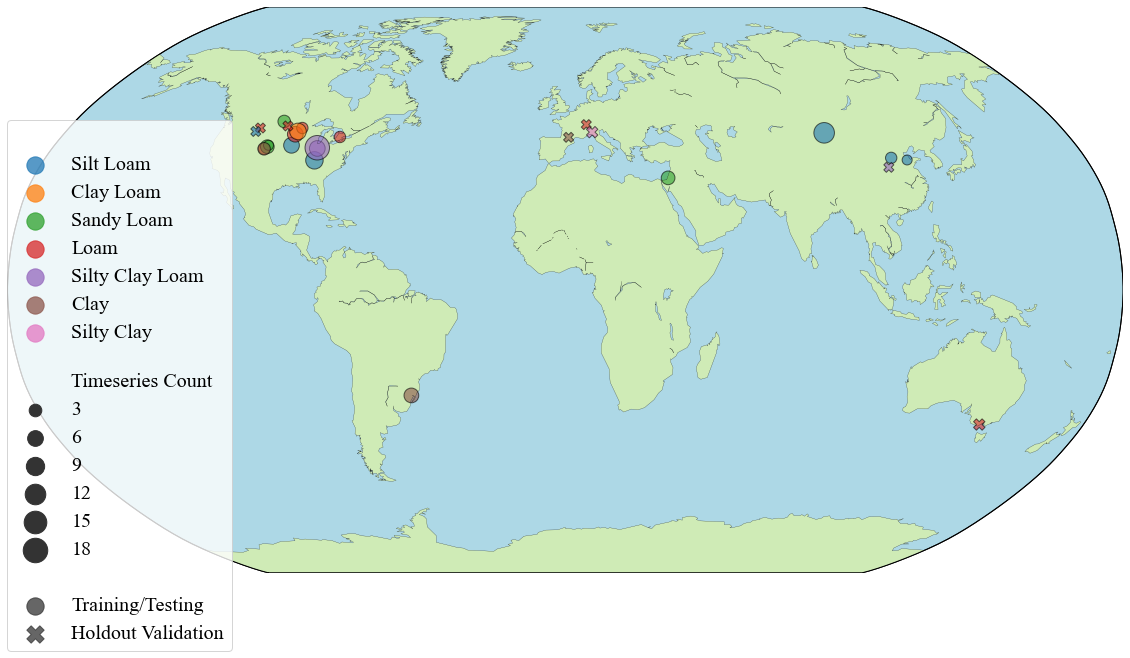

In [291]:
mapdf = pd.read_csv("map.csv")
# Order mapdf by Dataset Z to A
mapdf = mapdf.sort_values(by='Dataset', ascending=False)
from mpl_toolkits.basemap import Basemap

# When multiple rows have the same latitude and longitude, manually add  a small amount of noise to the latitude and longitude
# Get the indexes of rows where the lat/long combination is not unique
non_unique_indices = mapdf[mapdf.duplicated(subset=['Latitude', 'Longitude'], keep=False)].index

# Add a small amount of noise to the latitude and longitude
i = 0
for index in non_unique_indices:
    # if i is odd, add a small amount of noise to the latitude and longitude.
    if i % 2 == 1:
        mapdf.at[index, 'Latitude'] += 0.5
        mapdf.at[index, 'Longitude'] += 0.5
    # if i is even, subtract a small amount of noise to the latitude and longitude.
    else:
        mapdf.at[index, 'Latitude'] -= 0.5
        mapdf.at[index, 'Longitude'] -= 0.5
    i += 1


# Create a bubble map using seaborn
plt.figure(figsize=(20, 16))
m = Basemap(projection='robin', lon_0=0, lat_0=0, resolution='c')
m.fillcontinents(color='#CFEBB6', lake_color='lightblue')
m.drawmapboundary(fill_color='lightblue')
#m.drawcountries(linewidth=0.5, color='k')
m.drawcoastlines(linewidth=0.2, color='black')
# Plot bubbles
x, y = m(mapdf['Longitude'], mapdf['Latitude'])
# Vary shape of markers based on dataset
g = sns.scatterplot(x=x, y=y, size=mapdf['Treatments'], sizes=(100, 600),  alpha=0.6, hue=mapdf['Texture'], edgecolor='black' , linewidth=1, style=mapdf['Dataset'])

# Set legend font size
plt.rcParams['legend.fontsize'] = 20
# Set legend title font size
plt.rcParams['legend.title_fontsize'] = 20
plt.rc('font', family='Times New Roman')
# Set legend position

# Set the color legend marker size
handles, labels = g.get_legend_handles_labels()
for handle in handles[:8]:
    handle.set_sizes([300])
    # Set alpha
    handle.set_alpha(0.75)
for handle in handles[15:]:
    handle.set_sizes([300])
    # Set alpha
    handle.set_alpha(0.75)
# Set label
labels[0] = ''
labels[15] = ''
# Set font style to bold on 8th label
labels[8] = '\nTimeseries Count'

plt.legend(handles, labels, bbox_to_anchor=(0.00, 0.8), loc=2, borderaxespad=0., )


# Save seaborn plot as svg
plt.savefig('bubble_map.svg', dpi=600, bbox_inches='tight')
# Show the plot
plt.show()

In [ ]:
print(len(alldata.index))

6783


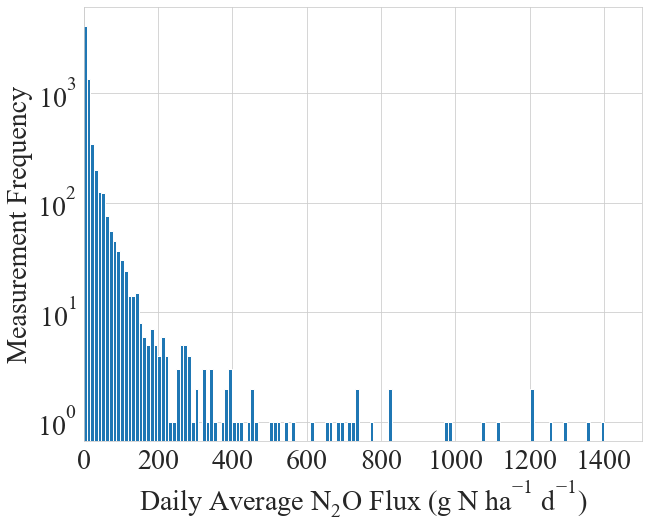

In [ ]:
# Create a histogram of the N2OFlux
# Set fig size
plt.figure(figsize=(10, 8))
# Get the range of the N2OFlux column
fluxrange = alldata['N2OFlux'].max() - alldata['N2OFlux'].min()
bins = int(fluxrange/10)
plt.hist(alldata['N2OFlux'], bins=bins)
plt.xlabel('Daily Average $\mathregular{N_{2}O}$ Flux (g N $\mathregular{ha^{-1}}$ $\mathregular{d^{-1}}$)')
plt.ylabel('Measurement Frequency')
# Use log scale for y axis
plt.yscale('log')
# set x min and max
plt.xlim(0, 1501)
# Set x ticks
plt.xticks(np.arange(0, 1401, 200))
# Set font size to 20
plt.rc('font', size=28)
# Save seaborn plot as svg
plt.savefig('N2OFlux_hist.svg', dpi=600, bbox_inches='tight')
plt.show()

Index(['<i>Zea mays</i> (Corn)', '<i>Glycine max</i> (Soybean)',
       '<i>Panicum virgatum</i> (Switchgrass)', 'Rangeland',
       '<i>Hordeum vulgare</i> (Barley)', 'Triticum aestivum (Spring Wheat)',
       'Pasture', '<i>Lolium perenne</i> (Ryegrass)',
       '<i>Medicago sativa</i> (Alfalfa)', 'Triticum aestivum (Wheat)',
       'Pisum sativum (Pea)', 'Miscanthus sinensis (Miscanthus)',
       'Restored Prairie', 'Sorghum bicolor (Sorghum)', 'Cotton',
       'Allium fistulosum (Onion)'],
      dtype='object')


/tmp/ipykernel_143406/3938816084.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<i><i>Zea  mays</i> </i>(Corn)
<i><i>Glycine  max</i> </i>(Soybean)
<i><i>Panicum  virgatum</i> </i>(Switchgrass)
<i><i>Hordeum  vulgare</i> </i>(Barley)
<i>Triticum  aestivum </i>(Spring Wheat)
<i><i>Lolium  perenne</i> </i>(Ryegrass)
<i><i>Medicago  sativa</i> </i>(Alfalfa)
<i>Triticum  aestivum </i>(Wheat)
<i>Pisum  sativum </i>(Pea)
<i>Miscanthus  sinensis </i>(Miscanthus)
<i>Sorghum  bicolor </i>(Sorghum)
<i>Allium  fistulosum </i>(Onion)


/tmp/ipykernel_143406/3938816084.py:54: UserWarning:

FixedFormatter should only be used together with FixedLocator



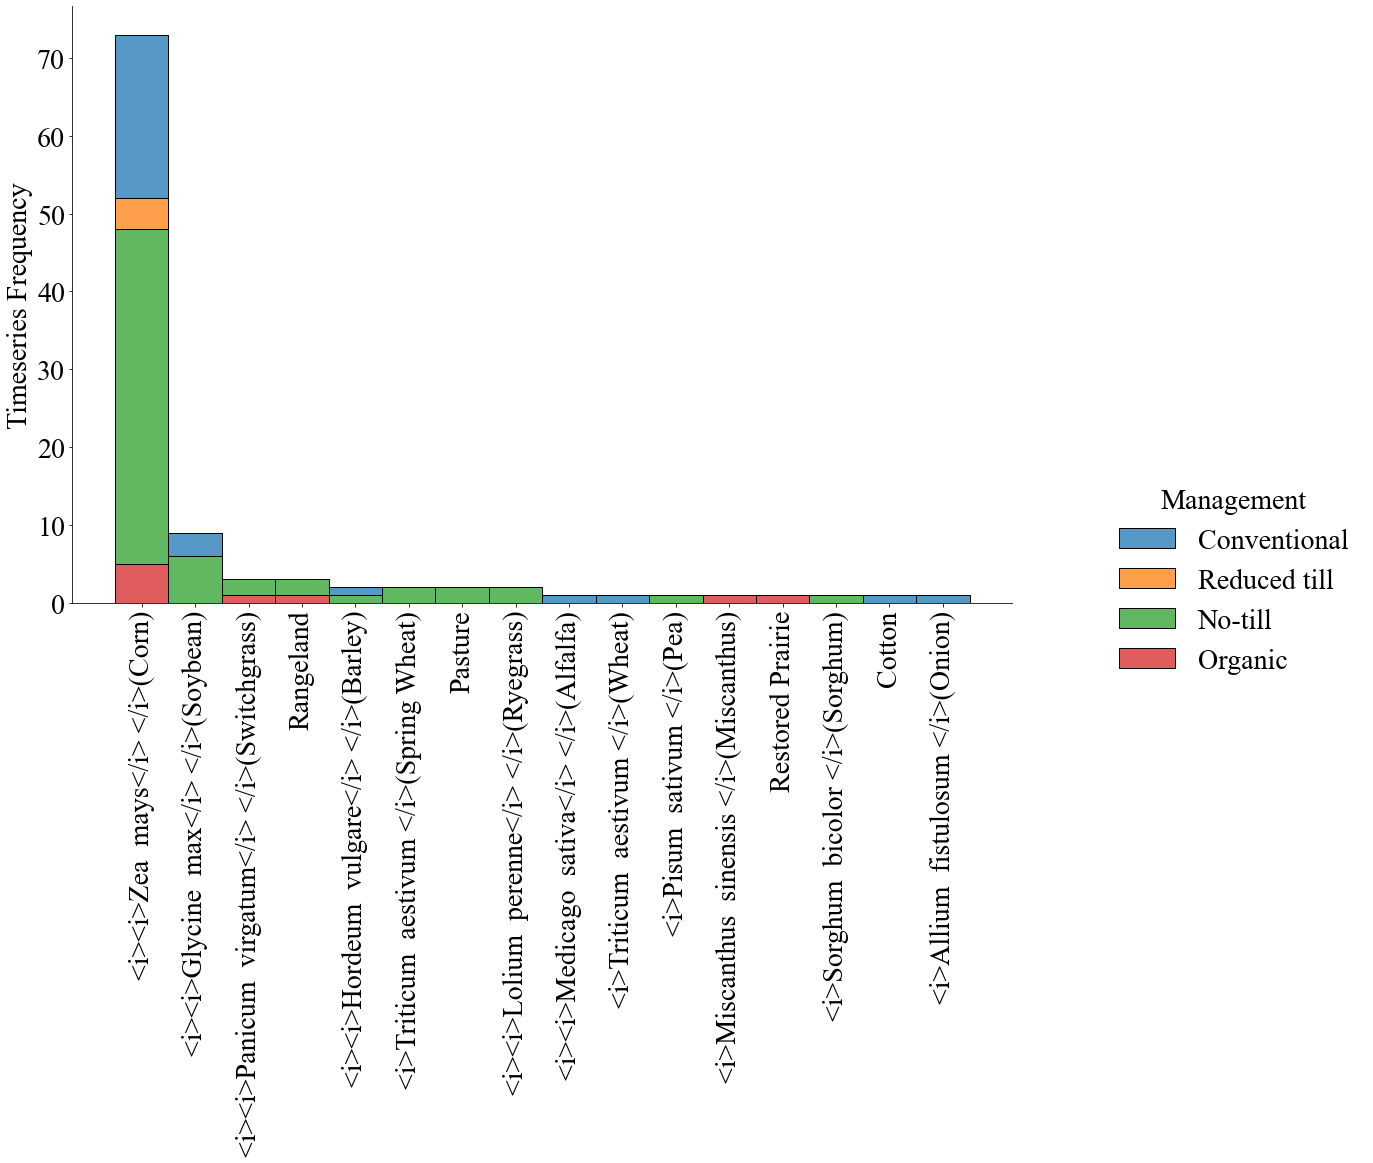

In [ ]:
# Set figure size
# Create a stacked bar graph of the number of treatment IDs with X as PrimaryCrop and hue as Management
bardata = alldata.drop_duplicates(subset='TreatmentID')

bardata.loc[bardata['PrimaryCrop'].str.contains('Corn'), 'PrimaryCrop'] = '<i>Zea mays</i> (Corn)'

bardata.loc[bardata['PrimaryCrop'].str.contains('Soy'), 'PrimaryCrop'] = '<i>Glycine max</i> (Soybean)'

bardata.loc[bardata['PrimaryCrop'].str.contains('Barley'), 'PrimaryCrop'] = '<i>Hordeum vulgare</i> (Barley)'

bardata.loc[bardata['PrimaryCrop'].str.contains('Alfalfa'), 'PrimaryCrop'] = '<i>Medicago sativa</i> (Alfalfa)'

bardata.loc[bardata['PrimaryCrop'].str.contains('Switchgrass'), 'PrimaryCrop'] = '<i>Panicum virgatum</i> (Switchgrass)'

bardata.loc[bardata['PrimaryCrop'].str.contains('Rye'), 'PrimaryCrop'] = '<i>Lolium perenne</i> (Ryegrass)'

vc = bardata['PrimaryCrop'].value_counts().index
print((vc))
bardata['PrimaryCrop'] = pd.Categorical(bardata['PrimaryCrop'], categories=vc, ordered=True)


plt.rc('font', size=28)
# Set font to times new roman
plt.rc('font', family='Times New Roman')
#plt.rc('text', usetex=True)
sns.displot(data=bardata, x='PrimaryCrop', hue='Management', multiple='stack', height=10, aspect=16/10)
plt.xticks(rotation=90)
# Set x axis label
plt.xlabel('')
# Set y axis label
plt.ylabel('Timeseries Frequency')


# Alter the x axis labels to italicize text up until the first parenthesis
plt.rcParams['text.usetex'] = False
italic_start = '<i>'
italic_end = '</i>'
for label in plt.gca().get_xticklabels():
    # If there is a parenthesis in the label, italicize the text up until the parenthesis
    if '(' in label.get_text():
        # Get the position of the first parenthesis
        pos = label.get_text().find('(')
        # Get the potition of the first  space
        space_pos = label.get_text().find(' ')
        # Add italic to the text up until the parenthesis
        label.set_text(italic_start + label.get_text()[:space_pos] + " " + label.get_text()[space_pos:pos] + italic_end + label.get_text()[pos:])
        # Print the label text
        print(label.get_text())

    else:
        label.set_fontstyle('normal')

# Update the x axis labels
plt.gca().set_xticklabels(plt.gca().get_xticklabels())

# Save seaborn plot as svg
plt.savefig('crop_mgmt_bar.svg', dpi=600, bbox_inches='tight')
plt.show()

[-0.2  0.   0.2  0.4  0.6  0.8]
[-20, 0, 20, 40, 60, 80]


/tmp/ipykernel_5780/2822031090.py:30: UserWarning:

FixedFormatter should only be used together with FixedLocator



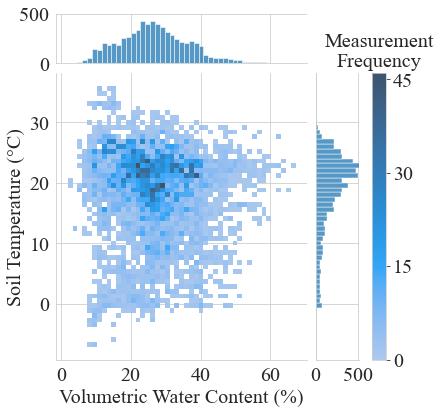

In [ ]:
# create a joint plot of a heatmap of VWC and SoilT with histograms of each using seaborn
# Multiply all values in VWC column by 100
#alldata['VWC'] = alldata['VWC'] / 100
plt.rc('font', size=20)

kdeplot = sns.jointplot(data=alldata, x='VWC', y='SoilT',  kind='hist', cbar=True, marginal_ticks=True, )
plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.1)
# get the current positions of the joint ax and the ax for the marginal x
pos_joint_ax = kdeplot.ax_joint.get_position()
pos_marg_x_ax = kdeplot.ax_marg_x.get_position()
# reposition the joint ax so it has the same width as the marginal x ax
kdeplot.ax_joint.set_position([pos_joint_ax.x0, pos_joint_ax.y0, pos_marg_x_ax.width, pos_joint_ax.height])
# reposition the colorbar using new x positions and y positions of the joint ax
kdeplot.fig.axes[-1].set_position([.83, pos_joint_ax.y0, .07, pos_joint_ax.height])
# Add colorbar title
kdeplot.fig.axes[-1].set_title('Measurement\nFrequency', fontsize=20)
# Set the histogram y limits
kdeplot.ax_marg_y.set_xlim(0,505)
kdeplot.ax_marg_x.set_ylim(0,500)
kdeplot.ax_marg_x.set_ylabel('')
kdeplot.ax_marg_y.set_xlabel('')
kdeplot.ax_joint.set_xlabel('Volumetric Water Content (%)')
kdeplot.ax_joint.set_ylabel('Soil Temperature (°C)')

# Set x axis tick labels to percentage (Multiply by 100)
xticks = kdeplot.ax_joint.get_xticks()
print(xticks)
xticks = [int(float(xtick)*100) for xtick in xticks]
print(xticks)
kdeplot.ax_joint.set_xticklabels(xticks)

# Set colorbar ticks
colorbar = kdeplot.fig.axes[-1]
colorbar.set_yticks([0, 15, 30, 45, ])
colorbar.set_yticklabels(['0', '15', '30', '45'])

# Save seaborn plot as svg
plt.savefig('VWC_SoilT_joint.svg', dpi=600, bbox_inches='tight')
plt.show()


In [ ]:
# Print the unique PrimaryCrop and Management
print(alldata['Management'].value_counts())
print(alldata['PrimaryCrop'].value_counts())


No-till         3957
Conventional    2290
Organic          377
Reduced till     129
Name: Management, dtype: int64
Zea mays (Corn)                     4739
Glycine max (Soybean)                608
Rangeland                            257
Pasture                              214
Panicum virgatum (Switchgrass)       181
Hordeum vulgare (Barley)             142
Allium fistulosum (Onion)             84
Triticum aestivum (Wheat)             80
Pisum sativum (Pea)                   68
Ryegrass                              67
Miscanthus sinensis (Miscanthus)      63
Sorghum bicolor (Sorghum)             56
Restored Prairie                      53
Medicago sativa (Alfalfa)             51
Triticum aestivum (Spring Wheat)      47
Cotton                                39
Corn, Cowpea                           4
Name: PrimaryCrop, dtype: int64


In [225]:
# Print the number of null rows in each column, sorted from most to least
alldata.isnull().sum().sort_values(ascending=False)
# Print the value counts of HMTruth
print(alldata['HMTruth'].value_counts())
# Print number of rows
print(len(alldata.index))

0.0    5133
1.0    1493
Name: HMTruth, dtype: int64
6626


In [226]:
# Print the unique experiment IDs
print(alldata['ExperimentID'].unique())

[ 4  6  8  9 22 24 27 29 30 32 35 37 39 42 43 44 45 49 50 51 53 54 55 57
 58]


In [227]:
# Randomly split the data into training and testing sets by experiment ID
#Print columns
print(alldata.columns)



Index(['RawID', 'ExperimentID', 'TreatmentID', 'Date', 'DOY', 'N2OFlux',
       'HMTruth', 'HMMCD', 'HMMAD', 'HMIQR', 'VWC', 'SoilT', 'Precip',
       'NitrogenApplied', 'PrimaryCrop', 'Management', 'SandMean', 'SiltMean',
       'ClayMean', 'MAP', 'MAT', 'Latitude', 'Longitude', 'PubTitle',
       'Citation', 'Year', 'Group', 'VWC_days_since_last_measurement',
       'VWC_days_until_next_measurement', 'days_since_precip', 'last_precip',
       'days_since_fert', 'last_fert', 'last_fert_type', 'vwc_dm1', 'vwc_dm2',
       'vwc_dm3', 'vwc_dm4', 'vwc_dm5', 'vwc_dm6', 'vwc_dm7', 'precip_dm1',
       'precip_dm2', 'precip_dm3', 'precip_dm4', 'precip_dm5', 'precip_dm6',
       'precip_dm7', 'soilT_dm1', 'soilT_dm2', 'soilT_dm3', 'soilT_dm4',
       'soilT_dm5', 'soilT_dm6', 'soilT_dm7', 'VWC_rollingmean',
       'SoilT_rollingmean'],
      dtype='object')


In [228]:
# Set X and Y
X = alldata.drop(['N2OFlux', 'TreatmentID', 'HMMCD', 'Date', 'RawID', 'HMTruth', 'PubTitle', 'Citation', 
'VWC_days_since_last_measurement', 'VWC_days_until_next_measurement', ], axis = 1)
Y = alldata[['HMMCD', 'HMTruth']]

# Scale continuous variables
X_cont = X.drop(['PrimaryCrop', 'Management', 'last_fert_type', 'ExperimentID', 'Group'], axis = 1)
scaler = MinMaxScaler()
cols = X_cont.columns
X_scale = scaler.fit_transform(X_cont.to_numpy())
X_cont = pd.DataFrame(X_scale, columns=cols)

# Scale nominal variables with one hot encoding
X_nom = X[['PrimaryCrop', 'Management', 'last_fert_type']]
X_nom = pd.concat([X_nom,pd.get_dummies(X_nom['last_fert_type'], prefix='NitrogenType')],axis=1)
X_nom = pd.concat([X_nom,pd.get_dummies(X_nom['PrimaryCrop'], prefix='PrimaryCrop')],axis=1)
X_nom = pd.concat([X_nom,pd.get_dummies(X_nom['Management'], prefix='Management')],axis=1)
#X_nom = pd.concat([X_nom,pd.get_dummies(X_nom['Tillage'], prefix='Tillage')],axis=1)
X_nom = X_nom.drop(['PrimaryCrop', 'Management', 'last_fert_type'], axis = 1)

X_cont.reset_index(drop=True, inplace=True)
X_nom.reset_index(drop=True, inplace=True)
scaled_df = pd.concat([X_cont, X_nom], axis=1, join='inner')
scaled_df['HMTruth'] = list(alldata['HMTruth'])
scaled_df['N2OFlux'] = list(alldata['N2OFlux'])
scaled_df['HMMCD'] = list(alldata['HMMCD'])
scaled_df['RawID'] = list(alldata['RawID'])
scaled_df['TreatmentID'] = list(alldata['TreatmentID'])
scaled_df['ExperimentID'] = list(alldata['ExperimentID'])
scaled_df['Group'] = list(alldata['Group'])

X = scaled_df.drop(['HMMCD', 'HMTruth', 'HMIQR', 'HMMAD', 'N2OFlux', 'NitrogenApplied'], axis = 1)
Y = scaled_df[['HMTruth', 'TreatmentID', 'RawID', 'HMMCD', 'NitrogenApplied', 'N2OFlux', 'last_fert', 'NitrogenType_ESN', 'NitrogenType_Urea',
               'NitrogenType_UAN', 'HMIQR', 'HMMAD', 'ExperimentID', 'Group']]
# Add unscaled 'VWC', 'SoilT', 'Precip' to Y
Y['VWC'] = list(alldata['VWC'])
Y['SoilT'] = list(alldata['SoilT'])

# Add last_fert_type to X
X_plus = X
X_plus['last_fert_type'] = list(alldata['last_fert_type'])
# Add the unscaled days_since_fert to X plus
X_plus['days_since_fert'] = list(alldata['days_since_fert'])


/tmp/ipykernel_4306/2783822799.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_4306/2783822799.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [229]:
# Get all the experimentids that only have one year of data, i.e. there is only one unique year associated with the experimentid
single_year_experiments = []
for id in alldata['ExperimentID'].unique():
    if len(alldata[alldata['ExperimentID'] == id]['Year'].unique()) == 1:
        single_year_experiments.append(id)
print(single_year_experiments)
# Print experiments with more than one year of data
multi_year_experiments = []
for id in alldata['ExperimentID'].unique():
    if len(alldata[alldata['ExperimentID'] == id]['Year'].unique()) > 1:
        multi_year_experiments.append(id)
print(multi_year_experiments)
# Drop Year column
alldata = alldata.drop(['Year'], axis = 1)

# Filter to only include multi-year experiments
X_multiyear_experiments = X[X['ExperimentID'].isin(multi_year_experiments)]
X_singleyear_experiments = X[X['ExperimentID'].isin(single_year_experiments)]
Y_multiyear_experiments = Y[Y['ExperimentID'].isin(multi_year_experiments)]
Y_singleyear_experiments = Y[Y['ExperimentID'].isin(single_year_experiments)]
X_plus_multiyear_experiments = X_plus[X_plus['ExperimentID'].isin(multi_year_experiments)]
X_plus_singleyear_experiments = X_plus[X_plus['ExperimentID'].isin(single_year_experiments)]



[4, 22, 29, 49, 53, 54, 57]
[6, 8, 9, 24, 27, 30, 32, 35, 37, 39, 42, 43, 44, 45, 50, 51, 55, 58]


In [230]:
# Save to csv
X_multiyear_experiments.to_csv("X_all-YEAR_SEPARATED.csv", index=False)
Y_multiyear_experiments.to_csv("Y_all-YEAR_SEPARATED.csv", index=False)
X_plus_multiyear_experiments.to_csv("X_plus-YEAR_SEPARATED.csv", index=False)
X_singleyear_experiments.to_csv("X_singleyear-YEAR_SEPARATED.csv", index=False)
Y_singleyear_experiments.to_csv("Y_singleyear-YEAR_SEPARATED.csv", index=False)
X_plus_singleyear_experiments.to_csv("X_plus_singleyear-YEAR_SEPARATED.csv", index=False)


In [232]:
# Load X and Y
X = pd.read_csv('X_all-YEAR_SEPARATED.csv')
Y = pd.read_csv('Y_all-YEAR_SEPARATED.csv')

## XGBoost Model

In [173]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedGroupKFold
from sklearn.metrics import make_scorer, matthews_corrcoef

random_grid = {
    'n_estimators': [100, 500, 1000, 2000],
    'max_depth': [10, 20, 30, 50, 110, 200, None],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5, 1],
    'subsample': [.7, 1],
    'min_split_loss': [2, 5, 10, 20],
    'max_delta_step': [0, 1, 2, 5, 10],
    'min_child_weight': [1, 2, 4, 6, 8],
    'alpha': [0, 1, 2, 5, 10, 13, 15, 20],
    'lambda': [0, 1, 2, 5, 10],
    'tree_method': ['approx', 'hist', 'exact'],
    'scale_pos_weight': [0.5, 1, 2, 5, 10],
    'nthread': [-1],
    }

# Load X and Y
X = pd.read_csv('X_all-YEAR_SEPARATED.csv')
Y = pd.read_csv('Y_all-YEAR_SEPARATED.csv')

# Use the random grid to search for best hyperparameters
# First create the base model to tune
xgb = XGBClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores and stratify the folds
groups = X['Group']
cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=1)
# Create MCC scorer
scorer = make_scorer(matthews_corrcoef)
xgb_random = RandomizedSearchCV(estimator = xgb, scoring='accuracy', param_distributions = random_grid, n_iter = 50, verbose=2, random_state=42, n_jobs = -1, cv=cv) # Fit the random search model
xgb_random.fit(X.drop(['TreatmentID', 'ExperimentID', 'RawID', 'Group'], axis = 1), Y['HMTruth'], groups=groups)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END alpha=13, lambda=1, learning_rate=0.1, max_delta_step=2, max_depth=50, min_child_weight=8, min_split_loss=20, n_estimators=100, nthread=-1, scale_pos_weight=2, subsample=0.7, tree_method=approx; total time=   2.6s
[CV] END alpha=13, lambda=1, learning_rate=0.1, max_delta_step=2, max_depth=50, min_child_weight=8, min_split_loss=20, n_estimators=100, nthread=-1, scale_pos_weight=2, subsample=0.7, tree_method=approx; total time=   3.1s
[CV] END alpha=13, lambda=1, learning_rate=0.1, max_delta_step=2, max_depth=50, min_child_weight=8, min_split_loss=20, n_estimators=100, nthread=-1, scale_pos_weight=2, subsample=0.7, tree_method=approx; total time=   3.6s
[CV] END alpha=13, lambda=1, learning_rate=0.1, max_delta_step=2, max_depth=50, min_child_weight=8, min_split_loss=20, n_estimators=100, nthread=-1, scale_pos_weight=2, subsample=0.7, tree_method=approx; total time=   2.8s
[CV] END alpha=13, lambda=1, learning_rate=0.1

RandomizedSearchCV(cv=StratifiedGroupKFold(n_splits=5, random_state=1, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           impo...
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2,
                                                          0.5, 1],
                                        'max_delta_step': [0, 1, 2, 5, 10],
                                        'max_depth': [10, 20, 30, 50, 110, 200,
                                                      None],
                                        'min_child_weight': [1, 2, 4, 6, 8],
                                        'min_split_loss': [2, 5, 10, 20],
                                        'n_estimators': [100, 500, 1000, 2000],
                                        'nthread': [-1],
                                        'scale_pos_weight': [0.5, 1, 2, 5, 10],
                                        'subsample': [0.7, 1],
                                        'tree_method': ['approx', 'hist',
                                                        'exact']},
                   random_state=42, scoring='accuracy', verbose=2)

In [175]:
print(xgb_random.best_params_)

{'tree_method': 'hist', 'subsample': 0.7, 'scale_pos_weight': 1, 'nthread': -1, 'n_estimators': 500, 'min_split_loss': 5, 'min_child_weight': 2, 'max_depth': None, 'max_delta_step': 2, 'learning_rate': 0.01, 'lambda': 0, 'alpha': 13}


In [308]:
# Implement a 10-fold cross validation manually
mcd_accuracy_list = []
mcd_mcc_list = []
mad_accuracy_list = []
mad_mcc_list = []
iqr_accuracy_list = []
iqr_mcc_list = []
true_accuracy_list = []
true_mcc_list = []
true_predictions = pd.DataFrame(columns=['RawID', 'HMTruth', 'Prediction'])
mcd_predictions = pd.DataFrame(columns=['RawID', 'HMTruth', 'Prediction'])
mad_predictions = pd.DataFrame(columns=['RawID', 'HMTruth', 'Prediction'])
iqr_predictions = pd.DataFrame(columns=['RawID', 'HMTruth', 'Prediction'])

xgb_classifier = XGBClassifier(tree_method='hist', subsample=0.7, scale_pos_weight=1, nthread=-1, n_estimators=500, 
     min_split_loss=5, min_child_weight=2, max_depth=None, max_delta_step=2, learning_rate=0.01, 
     reg_lambda=0, alpha=13)
     

# Segment the dataset into 10 equal and stratified parts
groups = X['Group']
folds = StratifiedGroupKFold(n_splits=10, shuffle=True, random_state=1).split(X, Y['HMTruth'], groups=groups)



In [309]:
X = pd.read_csv('X_all-YEAR_SEPARATED.csv')
Y = pd.read_csv('Y_all-YEAR_SEPARATED.csv')
# Drop last_fert_type column
X = X.drop(['last_fert_type'], axis=1)

# Iterate through the 10 folds
for train_index, test_index in folds:    
    # Get all the RawID values in the testing set
    test_raw_ids = X['RawID'].iloc[test_index]
    # Get the HMTruth values of Y where 'RawID' column value is in test_raw_ids
    test_truth = Y['HMTruth'].loc[Y['RawID'].isin(test_raw_ids)]
    # Get the TreatmentID values of X where 'RawID' column value is in test_raw_ids
    test_treatment_ids = X['TreatmentID'].loc[X['RawID'].isin(test_raw_ids)]
    test_fluxes = Y['N2OFlux'].loc[Y['RawID'].isin(test_raw_ids)]

    
    ######### MCD #########
    # Train the model on the training set
    xgb_classifier.fit(X.drop(['TreatmentID', 'ExperimentID', 'RawID', 'Group'], axis = 1).iloc[train_index], Y['HMMCD'].iloc[train_index])
    # Make predictions on the testing set
    predictions = xgb_classifier.predict(X.drop(['TreatmentID', 'ExperimentID', 'RawID', 'Group'], axis = 1).iloc[test_index])

    calibrated_clf = CalibratedClassifierCV(xgb_classifier, method='sigmoid', cv=5)
    calibrated_clf.fit(X.drop(['TreatmentID', 'ExperimentID', 'RawID', 'Group'], axis = 1).iloc[train_index], Y['HMMCD'].iloc[train_index])
    prediction_scores = calibrated_clf.predict_proba(X.drop(['TreatmentID', 'ExperimentID', 'RawID', 'Group'], axis = 1).iloc[test_index])
    prediction_scores = [score[1] for score in prediction_scores]

    # Calculate the accuracy of the predictions on the true labels
    accuracy = metrics.accuracy_score(test_truth, predictions)
    mcd_accuracy_list.append(accuracy)
    # Calculate the Matthews correlation coefficient of the predictions on the true labels
    mcc = metrics.matthews_corrcoef(test_truth, predictions)
    mcd_mcc_list.append(mcc)

    # Create a DataFrame with the RawID, TreatmentID, HMTruth, and predictions
    predictions_df = pd.DataFrame({'RawID': test_raw_ids, 'TreatmentID': test_treatment_ids, 'HMTruth': test_truth, 'N2OFlux': test_fluxes, 'Prediction': predictions, 'PredictionScore': prediction_scores})
    # Append the DataFrame to the true_predictions DataFrame
    mcd_predictions = pd.concat([mcd_predictions, predictions_df], ignore_index=True)
    

    ########## MAD #########
    # Train the model on the training set
    xgb_classifier.fit(X.drop(['TreatmentID', 'ExperimentID', 'RawID', 'Group'], axis = 1).iloc[train_index], Y['HMMAD'].iloc[train_index])
    # Make predictions on the testing set
    predictions = xgb_classifier.predict(X.drop(['TreatmentID', 'ExperimentID', 'RawID', 'Group'], axis = 1).iloc[test_index])
    # Calculate the accuracy of the predictions on the true labels
    accuracy = metrics.accuracy_score(test_truth, predictions)
    mad_accuracy_list.append(accuracy)
    # Calculate the Matthews correlation coefficient of the predictions on the true labels
    mcc = metrics.matthews_corrcoef(test_truth, predictions)
    mad_mcc_list.append(mcc)

    calibrated_clf = CalibratedClassifierCV(xgb_classifier, method='sigmoid', cv=5)
    calibrated_clf.fit(X.drop(['TreatmentID', 'RawID', 'ExperimentID', 'Group'], axis = 1).iloc[train_index], Y['HMMAD'].iloc[train_index])

    prediction_scores = calibrated_clf.predict_proba(X.drop(['TreatmentID', 'RawID', 'ExperimentID', 'Group'], axis = 1).iloc[test_index])
    prediction_scores = [score[1] for score in prediction_scores]
    # Create a DataFrame with the RawID, TreatmentID, HMTruth, and predictions
    predictions_df = pd.DataFrame({'RawID': test_raw_ids, 'TreatmentID': test_treatment_ids, 'HMTruth': test_truth, 'N2OFlux': test_fluxes, 'Prediction': predictions, 'PredictionScore': prediction_scores})
    # Append the DataFrame to the true_predictions DataFrame
    mad_predictions = pd.concat([mad_predictions, predictions_df], ignore_index=True)

    ########## IQR #########
    # Train the model on the training set
    xgb_classifier.fit(X.drop(['TreatmentID', 'RawID', 'ExperimentID', 'Group'], axis = 1).iloc[train_index], Y['HMIQR'].iloc[train_index])
    # Make predictions on the testing set
    predictions = xgb_classifier.predict(X.drop(['TreatmentID', 'RawID', 'ExperimentID', 'Group'], axis = 1).iloc[test_index])
    # Calculate the accuracy of the predictions on the true labels
    accuracy = metrics.accuracy_score(test_truth, predictions)
    iqr_accuracy_list.append(accuracy)
    # Calculate the Matthews correlation coefficient of the predictions on the true labels
    mcc = metrics.matthews_corrcoef(test_truth, predictions)
    iqr_mcc_list.append(mcc)

    calibrated_clf = CalibratedClassifierCV(xgb_classifier, method='sigmoid', cv=5)
    calibrated_clf.fit(X.drop(['TreatmentID', 'RawID', 'ExperimentID', 'Group'], axis = 1).iloc[train_index], Y['HMIQR'].iloc[train_index])

    prediction_scores = calibrated_clf.predict_proba(X.drop(['TreatmentID', 'RawID', 'ExperimentID', 'Group'], axis = 1).iloc[test_index])
    prediction_scores = [score[1] for score in prediction_scores]
    # Create a DataFrame with the RawID, TreatmentID, HMTruth, and predictions
    predictions_df = pd.DataFrame({'RawID': test_raw_ids, 'TreatmentID': test_treatment_ids, 'HMTruth': test_truth, 'N2OFlux': test_fluxes, 'Prediction': predictions, 'PredictionScore': prediction_scores})
    # Append the DataFrame to the true_predictions DataFrame
    iqr_predictions = pd.concat([iqr_predictions, predictions_df], ignore_index=True)

    ########## True ##########
    # Train the model on the training set
    xgb_classifier.fit(X.drop(['TreatmentID', 'RawID', 'ExperimentID', 'Group'], axis = 1).iloc[train_index], Y['HMTruth'].iloc[train_index])
    # Make predictions on the testing set
    predictions = xgb_classifier.predict(X.drop(['TreatmentID', 'RawID', 'ExperimentID', 'Group'], axis = 1).iloc[test_index])
    
    # Calculate the accuracy of the predictions on the true labels
    accuracy = metrics.accuracy_score(test_truth, predictions)
    true_accuracy_list.append(accuracy)
    # Calculate the Matthews correlation coefficient of the predictions on the true labels
    mcc = metrics.matthews_corrcoef(test_truth, predictions)
    true_mcc_list.append(mcc)

    calibrated_clf = CalibratedClassifierCV(xgb_classifier, method='sigmoid', cv=5)
    calibrated_clf.fit(X.drop(['TreatmentID', 'RawID', 'ExperimentID', 'Group'], axis = 1).iloc[train_index], Y['HMTruth'].iloc[train_index])
    prediction_scores = calibrated_clf.predict_proba(X.drop(['TreatmentID', 'RawID', 'ExperimentID', 'Group'], axis = 1).iloc[test_index])
    prediction_scores = [score[1] for score in prediction_scores]
    
    # Create a DataFrame with the RawID, TreatmentID, HMTruth, and predictions
    predictions_df = pd.DataFrame({'RawID': test_raw_ids, 'TreatmentID': test_treatment_ids, 'HMTruth': test_truth, 'N2OFlux': test_fluxes, 'Prediction': predictions})
    # Append the DataFrame to the true_predictions DataFrame
    true_predictions = pd.concat([true_predictions, predictions_df], ignore_index=True)
    


In [306]:
# Print the length of X and Y
print(len(X))
print(len(Y))
print(true_accuracy_list)
print(true_mcc_list)
# Print true positive rate
print("True Positive Rate:", np.sum(Y['HMTruth']) / len(Y))


6071
6071
[0.8492462311557789, 0.8303198887343533, 0.8216374269005848, 0.8445945945945946, 0.8044943820224719, 0.8242424242424242, 0.8337874659400545, 0.8203356367226061]
[0.5120405007589088, 0.5373159879255429, 0.2443378490929549, 0.6041814382323317, 0.41366290445174103, 0.40990351051802687, 0.39687887048247056, 0.4308680149280271]
True Positive Rate: 0.2294514906934607


In [310]:
 # Print the results
print("MCD Accuracy:", np.mean(mcd_accuracy_list))
print("MCD MCC:", np.mean(mcd_mcc_list))
print("MAD Accuracy:", np.mean(mad_accuracy_list))
print("MAD MCC:", np.mean(mad_mcc_list))
print("IQR Accuracy:", np.mean(iqr_accuracy_list))
print("IQR MCC:", np.mean(iqr_mcc_list))
print("True Accuracy:", np.mean(true_accuracy_list))
print("True MCC:", np.mean(true_mcc_list))

# print the lengths of the lists
print("MCD Accuracy List Length:", len(mcd_accuracy_list))
print("MCD MCC List Length:", len(mcd_mcc_list))
print("MAD Accuracy List Length:", len(mad_accuracy_list))
print("MAD MCC List Length:", len(mad_mcc_list))
print("IQR Accuracy List Length:", len(iqr_accuracy_list))
print("IQR MCC List Length:", len(iqr_mcc_list))
print("True Accuracy List Length:", len(true_accuracy_list))
print("True MCC List Length:", len(true_mcc_list))

# Save the fold results to a CSV
df = pd.DataFrame({'MCD Accuracy': mcd_accuracy_list[:], 'MCD MCC': mcd_mcc_list[:], 'MAD Accuracy': mad_accuracy_list[:], 'MAD MCC': mad_mcc_list[:],
                   'IQR Accuracy': iqr_accuracy_list[:], 'IQR MCC': iqr_mcc_list[:], 'True Accuracy': true_accuracy_list[:], 'True MCC': true_mcc_list[:]})
df.to_csv('fold_results.csv', index=False)
# Save predictions to a CSV
true_predictions.to_csv('xgb_true_predictions-YEAR-Separated.csv', index=False)
mcd_predictions.to_csv('xgb_mcd_predictions-YEAR-Separated.csv', index=False)
mad_predictions.to_csv('xgb_mad_predictions-YEAR-Separated.csv', index=False)
iqr_predictions.to_csv('xgb_iqr_predictions-YEAR-Separated.csv', index=False)

MCD Accuracy: 0.8389868049828502
MCD MCC: 0.47724862489684156
MAD Accuracy: 0.8344571084529717
MAD MCC: 0.4486732971161156
IQR Accuracy: 0.8154942616567942
IQR MCC: 0.3226867871810893
True Accuracy: 0.8382822135934728
True MCC: 0.4228756790665417
MCD Accuracy List Length: 10
MCD MCC List Length: 10
MAD Accuracy List Length: 10
MAD MCC List Length: 10
IQR Accuracy List Length: 10
IQR MCC List Length: 10
True Accuracy List Length: 10
True MCC List Length: 10


In [311]:
# For each unique treatmentID, calculate the time and flux percentage of HMTruth and predicted
performancedf = pd.DataFrame(columns=['TreatmentID', 'HMTruthTimePercentage', 'HMTruthFluxPercentage', 'PredictedTimePercentage', 'PredictedFluxPercentage'])
for treatmentID in mcd_predictions['TreatmentID'].unique():
    treatmentdf = mcd_predictions.loc[mcd_predictions['TreatmentID'] == treatmentID]
    # If HMTruth is always 0, 
    if treatmentdf['HMTruth'].value_counts()[0] == len(treatmentdf['HMTruth']):
        truehmtime = 0
        truehmflux = 0
    else:
        truehmtime = treatmentdf['HMTruth'].value_counts()[1] / len(treatmentdf['HMTruth'])
        truehmflux = treatmentdf.loc[treatmentdf['HMTruth'] == 1]['N2OFlux'].sum() / treatmentdf['N2OFlux'].sum()
    
    # If predicted is always 0
    if treatmentdf['Prediction'].value_counts()[0] == len(treatmentdf['Prediction']):
        predictedhmtime = 0
        predictedhmflux = 0
    else:
        predictedhmtime = treatmentdf['Prediction'].value_counts()[1] / len(treatmentdf['Prediction'])
    predictedhmflux = treatmentdf.loc[treatmentdf['Prediction'] == 1]['N2OFlux'].sum() / treatmentdf['N2OFlux'].sum()
    performancedf = performancedf.append({'TreatmentID': treatmentID, 'HMTruthTimePercentage': truehmtime, 'HMTruthFluxPercentage': truehmflux, 'PredictedTimePercentage': predictedhmtime, 'PredictedFluxPercentage': predictedhmflux}, ignore_index=True)

# Save performancedf to csv
performancedf.to_csv('testing_performance.csv', index=False)


# Print the percentage of N2O Flux where HMTruth is 1
print('HM Flux Percentage: ', mcd_predictions.loc[mcd_predictions['HMTruth'] == 1]['N2OFlux'].sum() / mcd_predictions['N2OFlux'].sum())
# Print the percent of days where HMTruth is 1
print('HM Truth Percentage: ', mcd_predictions['HMTruth'].value_counts()[1] / len(mcd_predictions['HMTruth']))
# Print the percentage of N2O Flux where predicted is 1
print('Predicted Flux Percentage: ', mcd_predictions.loc[mcd_predictions['Prediction'] == 1]['N2OFlux'].sum() / mcd_predictions['N2OFlux'].sum())
# Print the percent of days where predicted is 1
print('Predicted HM Percentage: ', mcd_predictions['Prediction'].value_counts()[1] / len(mcd_predictions['Prediction']))
print('')

print('Perfect Knowledge Multiplier: ', (mcd_predictions.loc[mcd_predictions['HMTruth'] == 1]['N2OFlux'].sum() / mcd_predictions['N2OFlux'].sum()) / (mcd_predictions['HMTruth'].value_counts()[1] / len(mcd_predictions['HMTruth'])))
print('Model Multiplier: ', (mcd_predictions.loc[mcd_predictions['Prediction'] == 1]['N2OFlux'].sum() / mcd_predictions['N2OFlux'].sum()) / (mcd_predictions['Prediction'].value_counts()[1] / len(mcd_predictions['Prediction'])))

/tmp/ipykernel_4306/2225879757.py:20: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_4306/2225879757.py:20: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_4306/2225879757.py:20: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_4306/2225879757.py:20: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_4306/2225879757.py:20: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_4306/2225879757.py:20: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future

HM Flux Percentage:  0.8037428878338261
HM Truth Percentage:  0.2294514906934607
Predicted Flux Percentage:  0.6133977823913529
Predicted HM Percentage:  0.19074287596771536

Perfect Knowledge Multiplier:  3.5028880632011186
Model Multiplier:  3.2158358695145974


In [317]:
# Train XGB model on the complete X dataset
import pickle

xgb_classifier = XGBClassifier(tree_method='hist', subsample=0.7, scale_pos_weight=1, nthread=-1, n_estimators=500, 
     min_split_loss=5, min_child_weight=2, max_depth=None, max_delta_step=2, learning_rate=0.01, 
     reg_lambda=0, alpha=13)
xgb_classifier.fit(X.drop(columns=['RawID', 'ExperimentID', 'TreatmentID', 'Group']), Y['HMTruth'])

# Pickle the model
with open('xgb_classifier.pkl', 'wb') as f:
    pickle.dump(xgb_classifier, f)



In [318]:
# Load the pickle file
with open('xgb_classifier.pkl', 'rb') as f:
    xgb_classifier = pickle.load(f)

In [322]:
# Load single year data
X_singleyear = pd.read_csv('X_singleyear-YEAR_SEPARATED.csv')
Y_singleyear = pd.read_csv('Y_singleyear-YEAR_SEPARATED.csv')

# Use ExperimentID 42 as holdout
X_holdout = X_singleyear
Y_holdout = Y_singleyear

# Predict on holdout
holdout_pred = xgb_classifier.predict(X_holdout.drop(columns=['RawID', 'ExperimentID', 'TreatmentID', 'Group', 'last_fert_type']))
# Add predictions to Y_holdout
Y_holdout['Predicted'] = holdout_pred


In [323]:
# Calculate MCC and Accuracy of holdout predictions
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score

mcc = matthews_corrcoef(Y_holdout['HMTruth'], holdout_pred)
accuracy = accuracy_score(Y_holdout['HMTruth'], holdout_pred)
print('MCC: ', mcc)
print('Accuracy: ', accuracy)
# Print true negative rate
print('True Negative Rate: ', Y_holdout['HMTruth'].value_counts()[0] / len(Y_holdout['HMTruth']))
print('')

# For each unique treatmentID, calculate the time and flux percentage of HMTruth and predicted
performancedf = pd.DataFrame(columns=['TreatmentID', 'HMTruthTimePercentage', 'HMTruthFluxPercentage', 'PredictedTimePercentage', 'PredictedFluxPercentage'])
for treatmentID in Y_holdout['TreatmentID'].unique():
    treatmentdf = Y_holdout.loc[Y_holdout['TreatmentID'] == treatmentID]
    # If HMTruth is always 0, 
    if treatmentdf['HMTruth'].value_counts()[0] == len(treatmentdf['HMTruth']):
        truehmtime = 0
        truehmflux = 0
    else:
        truehmtime = treatmentdf['HMTruth'].value_counts()[1] / len(treatmentdf['HMTruth'])
        truehmflux = treatmentdf.loc[treatmentdf['HMTruth'] == 1]['N2OFlux'].sum() / treatmentdf['N2OFlux'].sum()
    
    # If predicted is always 0
    if treatmentdf['Predicted'].value_counts()[0] == len(treatmentdf['Predicted']):
        predictedhmtime = 0
        predictedhmflux = 0
    else:
        predictedhmtime = treatmentdf['Predicted'].value_counts()[1] / len(treatmentdf['Predicted'])
    predictedhmflux = treatmentdf.loc[treatmentdf['Predicted'] == 1]['N2OFlux'].sum() / treatmentdf['N2OFlux'].sum()
    performancedf = performancedf.append({'TreatmentID': treatmentID, 'HMTruthTimePercentage': truehmtime, 'HMTruthFluxPercentage': truehmflux, 'PredictedTimePercentage': predictedhmtime, 'PredictedFluxPercentage': predictedhmflux}, ignore_index=True)

# Save performancedf to csv
performancedf.to_csv('validation_performance.csv', index=False)

MCC:  0.29765892525495413
Accuracy:  0.8144144144144144
True Negative Rate:  0.8198198198198198



/tmp/ipykernel_4306/4292200557.py:32: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_4306/4292200557.py:32: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_4306/4292200557.py:32: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_4306/4292200557.py:32: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_4306/4292200557.py:32: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_4306/4292200557.py:32: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future

In [324]:
# Use the fully trained model to predict on the training Y data
Y['Prediction'] = xgb_classifier.predict(X.drop(columns=['RawID', 'ExperimentID', 'TreatmentID', 'Group']))

# For each unique treatmentID, calculate the time and flux percentage of HMTruth and predicted
performancedf = pd.DataFrame(columns=['TreatmentID', 'HMTruthTimePercentage', 'HMTruthFluxPercentage', 'PredictedTimePercentage', 'PredictedFluxPercentage'])
for treatmentID in Y['TreatmentID'].unique():
    treatmentdf = Y.loc[Y['TreatmentID'] == treatmentID]
    # If HMTruth is always 0, 
    if treatmentdf['HMTruth'].value_counts()[0] == len(treatmentdf['HMTruth']):
        truehmtime = 0
        truehmflux = 0
    else:
        truehmtime = treatmentdf['HMTruth'].value_counts()[1] / len(treatmentdf['HMTruth'])
        truehmflux = treatmentdf.loc[treatmentdf['HMTruth'] == 1]['N2OFlux'].sum() / treatmentdf['N2OFlux'].sum()
    
    # If predicted is always 0
    if treatmentdf['Prediction'].value_counts()[0] == len(treatmentdf['Prediction']):
        predictedhmtime = 0
        predictedhmflux = 0
    else:
        predictedhmtime = treatmentdf['Prediction'].value_counts()[1] / len(treatmentdf['Prediction'])
    predictedhmflux = treatmentdf.loc[treatmentdf['Prediction'] == 1]['N2OFlux'].sum() / treatmentdf['N2OFlux'].sum()
    performancedf = performancedf.append({'TreatmentID': treatmentID, 'HMTruthTimePercentage': truehmtime, 'HMTruthFluxPercentage': truehmflux, 'PredictedTimePercentage': predictedhmtime, 'PredictedFluxPercentage': predictedhmflux}, ignore_index=True)

# Save performancedf to csv
performancedf.to_csv('training_performance.csv', index=False)



/tmp/ipykernel_4306/1869081895.py:23: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_4306/1869081895.py:23: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_4306/1869081895.py:23: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_4306/1869081895.py:23: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_4306/1869081895.py:23: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_4306/1869081895.py:23: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future

In [237]:
import pickle
# save the model to disk
filename = 'XGB_classification_model.sav'
pickle.dump(xgb_classifier, open(filename, 'wb'))

# MLP Model

In [ ]:
from sklearn.neural_network import MLPClassifier

random_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100), (50, 50, 50), (100, 100, 100)],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'max_iter': [100, 200, 500, 1000],
    'early_stopping': [True],
    'validation_fraction': [0.1, 0.2, 0.3],
}

# Load X and Y
X = pd.read_csv('X_all.csv')
Y = pd.read_csv('Y_all.csv')

# Use the random grid to search for best hyperparameters
# First create the base model to tune
mlp = MLPClassifier()
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores and stratify the folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
mlp_random = RandomizedSearchCV(estimator = mlp, param_distributions = random_grid, n_iter = 100, cv = cv, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
mlp_random.fit(X.drop(['TreatmentID', 'RawID', 'last_fert_type', 'Category', 'Category2'], axis = 1), Y['HMTruth'])
# View the best parameters
print("Best Parameters:", mlp_random.best_params_)

In [124]:
# Print the best parameters
print("Best Parameters:", mlp_random.best_params_)

Best Parameters: {'validation_fraction': 0.2, 'solver': 'adam', 'max_iter': 500, 'learning_rate': 'invscaling', 'hidden_layer_sizes': (100, 100), 'early_stopping': True, 'alpha': 0.001, 'activation': 'tanh'}


In [130]:
# Implement a 10-fold cross validation manually
mcd_accuracy_list = []
mcd_mcc_list = []
mad_accuracy_list = []
mad_mcc_list = []
iqr_accuracy_list = []
iqr_mcc_list = []
true_accuracy_list = []
true_mcc_list = []
true_mlp_predictions = pd.DataFrame(columns=['RawID', 'HMTruth', 'Prediction', 'PredictionScore'])
mcd_mlp_predictions = pd.DataFrame(columns=['RawID', 'HMTruth', 'Prediction', 'PredictionScore'])
mad_mlp_predictions = pd.DataFrame(columns=['RawID', 'HMTruth', 'Prediction', 'PredictionScore'])
iqr_mlp_predictions = pd.DataFrame(columns=['RawID', 'HMTruth', 'Prediction', 'PredictionScore'])
X = pd.read_csv('X_all.csv')

mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,100), activation='tanh', solver='adam', alpha=0.001,
                               learning_rate='invscaling', max_iter=500, early_stopping=True, validation_fraction=0.2)

# Segment the dataset into 10 equal and stratified parts
folds = list(StratifiedKFold(n_splits=10, shuffle=True, random_state=1).split(X, Y['HMTruth']))

# Iterate through the 10 folds
for train_index, test_index in folds:
    # Get all the RawID values in the testing set
    test_raw_ids = X['RawID'].iloc[test_index]
    # Get the HMTruth values of Y where 'RawID' column value is in test_raw_ids
    test_truth = Y.loc[Y['RawID'].isin(test_raw_ids), 'HMTruth']

    ######### MCD #########
    # Train the model on the training set
    mlp_classifier.fit(X.drop(['TreatmentID', 'RawID', 'last_fert_type', 'Category', 'Category2'], axis = 1).iloc[train_index], Y['HMMCD'].iloc[train_index])
    # Make predictions on the testing set
    predictions = mlp_classifier.predict(X.drop(['TreatmentID', 'RawID', 'last_fert_type', 'Category', 'Category2'], axis = 1).iloc[test_index])
    # Get the prediction scores
    prediction_scores = mlp_classifier.predict_proba(X.drop(['TreatmentID', 'RawID', 'last_fert_type', 'Category', 'Category2'], axis = 1).iloc[test_index])
    # For each 2D array in prediction_scores, get the second value
    prediction_scores = [score[1] for score in prediction_scores]
    # Calculate the accuracy of the predictions on the true labels
    accuracy = metrics.accuracy_score(test_truth, predictions)
    mcd_accuracy_list.append(accuracy)
    # Calculate the Matthews correlation coefficient of the predictions on the true labels
    mcc = metrics.matthews_corrcoef(test_truth, predictions)
    mcd_mcc_list.append(mcc)
    # Create a DataFrame with the RawID, HMTruth, and predictions
    predictions_df = pd.DataFrame({'RawID': test_raw_ids, 'HMTruth': test_truth, 'Prediction': predictions, 'PredictionScore': prediction_scores})
    # Append the DataFrame to the true_predictions DataFrame
    mcd_mlp_predictions = pd.concat([mcd_mlp_predictions, predictions_df], ignore_index=True)

    ######### MAD #########
    # Train the model on the training set
    mlp_classifier.fit(X.drop(['TreatmentID', 'RawID', 'last_fert_type', 'Category', 'Category2'], axis = 1).iloc[train_index], Y['HMMAD'].iloc[train_index])
    # Make predictions on the testing set
    predictions = mlp_classifier.predict(X.drop(['TreatmentID', 'RawID', 'last_fert_type', 'Category', 'Category2'], axis = 1).iloc[test_index])
    # Get the prediction scores
    prediction_scores = mlp_classifier.predict_proba(X.drop(['TreatmentID', 'RawID', 'last_fert_type', 'Category', 'Category2'], axis = 1).iloc[test_index])
    # For each 2D array in prediction_scores, get the second value
    prediction_scores = [score[1] for score in prediction_scores]
    # Calculate the accuracy of the predictions on the true labels
    accuracy = metrics.accuracy_score(test_truth, predictions)
    mad_accuracy_list.append(accuracy)
    # Calculate the Matthews correlation coefficient of the predictions on the true labels
    mcc = metrics.matthews_corrcoef(test_truth, predictions)
    mad_mcc_list.append(mcc)
    # Create a DataFrame with the RawID, HMTruth, and predictions
    predictions_df = pd.DataFrame({'RawID': test_raw_ids, 'HMTruth': test_truth, 'Prediction': predictions, 'PredictionScore': prediction_scores})
    # Append the DataFrame to the true_predictions DataFrame
    mad_mlp_predictions = pd.concat([mad_mlp_predictions, predictions_df], ignore_index=True)

    ######### IQR #########
    # Train the model on the training set
    mlp_classifier.fit(X.drop(['TreatmentID', 'RawID', 'last_fert_type', 'Category', 'Category2'], axis = 1).iloc[train_index], Y['HMIQR'].iloc[train_index])
    # Make predictions on the testing set
    predictions = mlp_classifier.predict(X.drop(['TreatmentID', 'RawID', 'last_fert_type', 'Category', 'Category2'], axis = 1).iloc[test_index])
    # Get the prediction scores
    prediction_scores = mlp_classifier.predict_proba(X.drop(['TreatmentID', 'RawID', 'last_fert_type', 'Category', 'Category2'], axis = 1).iloc[test_index])
    # For each 2D array in prediction_scores, get the second value
    prediction_scores = [score[1] for score in prediction_scores]
    # Calculate the accuracy of the predictions on the true labels
    accuracy = metrics.accuracy_score(test_truth, predictions)
    iqr_accuracy_list.append(accuracy)
    # Calculate the Matthews correlation coefficient of the predictions on the true labels
    mcc = metrics.matthews_corrcoef(test_truth, predictions)
    iqr_mcc_list.append(mcc)
    # Create a DataFrame with the RawID, HMTruth, and predictions
    predictions_df = pd.DataFrame({'RawID': test_raw_ids, 'HMTruth': test_truth, 'Prediction': predictions, 'PredictionScore': prediction_scores})
    # Append the DataFrame to the true_predictions DataFrame
    iqr_mlp_predictions = pd.concat([iqr_mlp_predictions, predictions_df], ignore_index=True)

    ########## True ##########
    # Train the model on the training set
    mlp_classifier.fit(X.drop(['TreatmentID', 'RawID', 'last_fert_type', 'Category', 'Category2'], axis = 1).iloc[train_index], Y['HMTruth'].iloc[train_index])
    # Make predictions on the testing set
    predictions = mlp_classifier.predict(X.drop(['TreatmentID', 'RawID', 'last_fert_type', 'Category', 'Category2'], axis = 1).iloc[test_index])
    # Get the prediction scores
    prediction_scores = mlp_classifier.predict_proba(X.drop(['TreatmentID', 'RawID', 'last_fert_type', 'Category', 'Category2'], axis = 1).iloc[test_index])
    # For each 2D array in prediction_scores, get the second value
    prediction_scores = [score[1] for score in prediction_scores]
    # Calculate the accuracy of the predictions on the true labels
    accuracy = metrics.accuracy_score(test_truth, predictions)
    true_accuracy_list.append(accuracy)
    # Calculate the Matthews correlation coefficient of the predictions on the true labels
    mcc = metrics.matthews_corrcoef(test_truth, predictions)
    true_mcc_list.append(mcc)
    # Create a DataFrame with the RawID, HMTruth, and predictions
    predictions_df = pd.DataFrame({'RawID': test_raw_ids, 'HMTruth': test_truth, 'Prediction': predictions, 'PredictionScore': prediction_scores})
    # Append the DataFrame to the true_predictions DataFrame
    true_mlp_predictions = pd.concat([true_mlp_predictions, predictions_df], ignore_index=True)

/home/ryan/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/home/ryan/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/home/ryan/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/home/ryan/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/home/ryan/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/home/ryan/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted 

In [133]:
# Print the accuracy and Matthews correlation coefficient for each fold
print(f"Accuracy for MCD: {np.mean(mcd_accuracy_list)}")
print(f"MCC for MCD: {np.mean(mcd_mcc_list)}")
print(f"Accuracy for MAD: {np.mean(mad_accuracy_list)}")
print(f"MCC for MAD: {np.mean(mad_mcc_list)}")
print(f"Accuracy for IQR: {np.mean(iqr_accuracy_list)}")
print(f"MCC for IQR: {np.mean(iqr_mcc_list)}")
print(f"Accuracy for True: {np.mean(true_accuracy_list)}")
print(f"MCC for True: {np.mean(true_mcc_list)}")

# Save the fold results to a CSV
fold_results = pd.DataFrame({
    'Fold': np.arange(1, 11),
    'MCD Accuracy': mcd_accuracy_list,
    'MCD MCC': mcd_mcc_list,
    'MAD Accuracy': mad_accuracy_list,
    'MAD MCC': mad_mcc_list,
    'IQR Accuracy': iqr_accuracy_list,
    'IQR MCC': iqr_mcc_list,
    'True Accuracy': true_accuracy_list,
    'True MCC': true_mcc_list
})

fold_results.to_csv('mlp_fold_results.csv', index=False)
# Save predictions to a CSV
true_mlp_predictions.to_csv('true_mlp_predictions.csv', index=False)
mcd_mlp_predictions.to_csv('mcd_mlp_predictions.csv', index=False)
mad_mlp_predictions.to_csv('mad_mlp_predictions.csv', index=False)
iqr_mlp_predictions.to_csv('iqr_mlp_predictions.csv', index=False)

Accuracy for MCD: 0.8492542187157571
MCC for MCD: 0.5458628291597415
Accuracy for MAD: 0.8499910146833225
MCC for MAD: 0.5435314857124758
Accuracy for IQR: 0.8356261231645847
MCC for IQR: 0.4650221011972042
Accuracy for True: 0.8585798816568048
MCC for True: 0.5630217136440996


 ## Random Forext Model


In [134]:
random_grid = {
    'n_estimators': [100, 500, 1000, 2500, 5000],
    'max_depth': [10, 20, 30, 50, 80, 110, None],
    'criterion': ['gini', 'entropy'],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_leaf_nodes': [None, 10, 20],
    'bootstrap': [True, False],
    }

# Load X and Y
X = pd.read_csv('X_all.csv')
Y = pd.read_csv('Y_all.csv')

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores and stratify the folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
rf_random = RandomizedSearchCV(estimator = rf, scoring='accuracy', param_distributions = random_grid, n_iter = 50, verbose=2, random_state=0, n_jobs = -1, cv=cv) # Fit the random search model
rf_random.fit(X.drop(['TreatmentID', 'RawID', 'last_fert_type', 'Category', 'Category2'], axis = 1), Y['HMTruth'])



Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END bootstrap=False, criterion=entropy, max_depth=110, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=4, min_samples_split=10, n_estimators=5000; total time= 1.6min
[CV] END bootstrap=True, criterion=entropy, max_depth=20, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_samples_split=5, n_estimators=5000; total time= 2.2min


/home/ryan/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



[CV] END bootstrap=True, criterion=gini, max_depth=None, max_features=log2, max_leaf_nodes=None, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; total time=  15.6s
[CV] END bootstrap=False, criterion=entropy, max_depth=110, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=4, min_samples_split=10, n_estimators=5000; total time= 1.5min
[CV] END bootstrap=True, criterion=entropy, max_depth=20, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_samples_split=5, n_estimators=5000; total time= 2.0min
[CV] END bootstrap=True, criterion=gini, max_depth=None, max_features=log2, max_leaf_nodes=None, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; total time=  16.6s
[CV] END bootstrap=False, criterion=entropy, max_depth=110, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=4, min_samples_split=10, n_estimators=5000; total time= 1.5min
[CV] END bootstrap=True, criterion=entropy, max_depth=20, max_features=auto, max_leaf_nodes=None, min_samples_leaf=

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
                   estimator=RandomForestClassifier(), n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 20, 30, 50, 80, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'max_leaf_nodes': [None, 10, 20],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 500, 1000, 2500,
                                                         5000]},
                   random_state=0, scoring='accuracy', verb

In [135]:
# Print the best parameters
print(rf_random.best_params_)

{'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_leaf_nodes': None, 'max_features': 'sqrt', 'max_depth': 20, 'criterion': 'gini', 'bootstrap': False}


In [137]:
# Implement a 10-fold cross validation manually
mcd_accuracy_list = []
mcd_mcc_list = []
mad_accuracy_list = []
mad_mcc_list = []
iqr_accuracy_list = []
iqr_mcc_list = []
true_accuracy_list = []
true_mcc_list = []
true_rf_predictions = pd.DataFrame(columns=['RawID', 'HMTruth', 'Prediction', 'PredictionScore'])
mcd_rf_predictions = pd.DataFrame(columns=['RawID', 'HMTruth', 'Prediction', 'PredictionScore'])
mad_rf_predictions = pd.DataFrame(columns=['RawID', 'HMTruth', 'Prediction', 'PredictionScore'])
iqr_rf_predictions = pd.DataFrame(columns=['RawID', 'HMTruth', 'Prediction', 'PredictionScore'])

rf_classifier = RandomForestClassifier(n_estimators= 500, min_samples_split= 5, max_depth= 20,
                                    criterion='gini', min_samples_leaf=1, max_features='sqrt', bootstrap='False',)

# Segment the dataset into 10 equal and stratified parts
folds = list(StratifiedKFold(n_splits=10, shuffle=True, random_state=1).split(X, Y['HMTruth']))
X = X.drop(['last_fert_type', 'Category', 'Category2'], axis = 1)

# Iterate through the 10 folds
for train_index, test_index in folds:
    # Get all the RawID values in the testing set
    test_raw_ids = X['RawID'].iloc[test_index]
    # Get the HMTruth values of Y where 'RawID' column value is in test_raw_ids
    test_truth = Y['HMTruth'].loc[Y['RawID'].isin(test_raw_ids)]

    ######### MCD #########
    # Train the model on the training set
    rf_classifier.fit(X.drop(['TreatmentID', 'RawID'], axis = 1).iloc[train_index], Y['HMMCD'].iloc[train_index])
    # Make predictions on the testing set
    predictions = rf_classifier.predict(X.drop(['TreatmentID', 'RawID'], axis = 1).iloc[test_index])
    # Get the prediction scores
    prediction_scores = rf_classifier.predict_proba(X.drop(['TreatmentID', 'RawID'], axis = 1).iloc[test_index])
    # For each 2D array in prediction_scores, get the second value
    prediction_scores = [score[1] for score in prediction_scores]
    # Calculate the accuracy of the predictions on the true labels
    accuracy = metrics.accuracy_score(test_truth, predictions)
    mcd_accuracy_list.append(accuracy)
    # Calculate the Matthews correlation coefficient of the predictions on the true labels
    mcc = metrics.matthews_corrcoef(test_truth, predictions)
    mcd_mcc_list.append(mcc)
    # Create a DataFrame with the RawID, HMTruth, and predictions
    predictions_df = pd.DataFrame({'RawID': test_raw_ids, 'HMTruth': test_truth, 'Prediction': predictions, 'PredictionScore': prediction_scores})
    # Append the DataFrame to the true_predictions DataFrame
    mcd_rf_predictions = pd.concat([mcd_rf_predictions, predictions_df], ignore_index=True)

    ########## MAD #########
    # Train the model on the training set
    rf_classifier.fit(X.drop(['TreatmentID', 'RawID'], axis = 1).iloc[train_index], Y['HMMAD'].iloc[train_index])
    # Make predictions on the testing set
    predictions = rf_classifier.predict(X.drop(['TreatmentID', 'RawID',], axis = 1).iloc[test_index])
    # Get the prediction scores
    prediction_scores = rf_classifier.predict_proba(X.drop(['TreatmentID', 'RawID'], axis = 1).iloc[test_index])
    # For each 2D array in prediction_scores, get the second value
    prediction_scores = [score[1] for score in prediction_scores]
    # Calculate the accuracy of the predictions on the true labels
    accuracy = metrics.accuracy_score(test_truth, predictions)
    mad_accuracy_list.append(accuracy)
    # Calculate the Matthews correlation coefficient of the predictions on the true labels
    mcc = metrics.matthews_corrcoef(test_truth, predictions)
    mad_mcc_list.append(mcc)
    # Create a DataFrame with the RawID, HMTruth, and predictions
    predictions_df = pd.DataFrame({'RawID': test_raw_ids, 'HMTruth': test_truth, 'Prediction': predictions, 'PredictionScore': prediction_scores})
    # Append the DataFrame to the true_predictions DataFrame
    mad_rf_predictions = pd.concat([mad_rf_predictions, predictions_df], ignore_index=True)

    ########## IQR #########
    # Train the model on the training set
    rf_classifier.fit(X.drop(['TreatmentID', 'RawID'], axis = 1).iloc[train_index], Y['HMIQR'].iloc[train_index])
    # Make predictions on the testing set
    predictions = rf_classifier.predict(X.drop(['TreatmentID', 'RawID'], axis = 1).iloc[test_index])
    # Get the prediction scores
    prediction_scores = rf_classifier.predict_proba(X.drop(['TreatmentID', 'RawID'], axis = 1).iloc[test_index])
    # For each 2D array in prediction_scores, get the second value
    prediction_scores = [score[1] for score in prediction_scores]
    # Calculate the accuracy of the predictions on the true labels
    accuracy = metrics.accuracy_score(test_truth, predictions)
    iqr_accuracy_list.append(accuracy)
    # Calculate the Matthews correlation coefficient of the predictions on the true labels
    mcc = metrics.matthews_corrcoef(test_truth, predictions)
    iqr_mcc_list.append(mcc)
    # Create a DataFrame with the RawID, HMTruth, and predictions
    predictions_df = pd.DataFrame({'RawID': test_raw_ids, 'HMTruth': test_truth, 'Prediction': predictions, 'PredictionScore': prediction_scores})
    # Append the DataFrame to the true_predictions DataFrame
    iqr_rf_predictions = pd.concat([iqr_rf_predictions, predictions_df], ignore_index=True)

    ########## True ##########
    # Train the model on the training set
    rf_classifier.fit(X.drop(['TreatmentID', 'RawID'], axis = 1).iloc[train_index], Y['HMTruth'].iloc[train_index])
    # Make predictions on the testing set
    predictions = rf_classifier.predict(X.drop(['TreatmentID', 'RawID'], axis = 1).iloc[test_index])
    # Get the prediction scores
    prediction_scores = rf_classifier.predict_proba(X.drop(['TreatmentID', 'RawID'], axis = 1).iloc[test_index])
    # For each 2D array in prediction_scores, get the second value
    prediction_scores = [score[1] for score in prediction_scores]
    # Calculate the accuracy of the predictions on the true labels
    accuracy = metrics.accuracy_score(test_truth, predictions)
    true_accuracy_list.append(accuracy)
    # Calculate the Matthews correlation coefficient of the predictions on the true labels
    mcc = metrics.matthews_corrcoef(test_truth, predictions)
    true_mcc_list.append(mcc)
    # Create a DataFrame with the RawID, HMTruth, and predictions
    predictions_df = pd.DataFrame({'RawID': test_raw_ids, 'HMTruth': test_truth, 'Prediction': predictions, 'PredictionScore': prediction_scores})
    # Append the DataFrame to the true_predictions DataFrame
    true_rf_predictions = pd.concat([true_rf_predictions, predictions_df], ignore_index=True)


In [139]:
# Print the accuracy and Matthews correlation coefficient for each fold
print(f"Accuracy for MCD: {np.mean(mcd_accuracy_list)}")
print(f"MCC for MCD: {np.mean(mcd_mcc_list)}")
print(f"Accuracy for MAD: {np.mean(mad_accuracy_list)}")
print(f"MCC for MAD: {np.mean(mad_mcc_list)}")
print(f"Accuracy for IQR: {np.mean(iqr_accuracy_list)}")
print(f"MCC for IQR: {np.mean(iqr_mcc_list)}")
print(f"Accuracy for True: {np.mean(true_accuracy_list)}")
print(f"MCC for True: {np.mean(true_mcc_list)}")

# Save the fold results to a CSV
fold_results = pd.DataFrame({
    'Fold': np.arange(1, 11),
    'MCD Accuracy': mcd_accuracy_list,
    'MCD MCC': mcd_mcc_list,
    'MAD Accuracy': mad_accuracy_list,
    'MAD MCC': mad_mcc_list,
    'IQR Accuracy': iqr_accuracy_list,
    'IQR MCC': iqr_mcc_list,
    'True Accuracy': true_accuracy_list,
    'True MCC': true_mcc_list
})
fold_results.to_csv('rf_fold_results.csv', index=False)
# Save predictions to a CSV
true_rf_predictions.to_csv('true_rf_predictions.csv', index=False)
mcd_rf_predictions.to_csv('mcd_rf_predictions.csv', index=False)
mad_rf_predictions.to_csv('mad_rf_predictions.csv', index=False)
iqr_rf_predictions.to_csv('iqr_rf_predictions.csv', index=False)

Accuracy for MCD: 0.8664299802761342
MCC for MCD: 0.6205710008335091
Accuracy for MAD: 0.8750197238658778
MCC for MAD: 0.6342328792321548
Accuracy for IQR: 0.8634689896997589
MCC for IQR: 0.5718460721356927
Accuracy for True: 0.8918965592811745
MCC for True: 0.6745546358121547


In [141]:
# Train the model on the entire dataset
rf_classifier = RandomForestClassifier(n_estimators= 500, min_samples_split= 5, max_depth= 20,
                                    criterion='gini', min_samples_leaf=1, max_features='sqrt', bootstrap='False',)
rf_classifier.fit(X.drop(['TreatmentID', 'RawID',], axis = 1), Y['HMTruth'])

RandomForestClassifier(bootstrap='False', max_depth=20, max_features='sqrt',
                       min_samples_split=5, n_estimators=500)

In [142]:
# Save the RF model
import pickle
filename = 'RF_classification_model.sav'
pickle.dump(rf_classifier, open(filename, 'wb'))

## KNN Model

In [83]:
from sklearn.neighbors import KNeighborsClassifier
random_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2],
    'leaf_size': [10, 30, 40, 50],
}

knn_classifier = KNeighborsClassifier()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
knn_random = RandomizedSearchCV(estimator = knn_classifier, scoring='accuracy', param_distributions = random_grid, n_iter = 20, verbose=2, random_state=42, n_jobs = -1, cv=cv) # Fit the random search model
knn_random.fit(X.drop(['TreatmentID', 'RawID'], axis = 1), Y['HMTruth'])

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
                   estimator=KNeighborsClassifier(), n_iter=20, n_jobs=-1,
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                                        'leaf_size': [10, 30, 40, 50],
                                        'n_neighbors': [3, 5, 7, 9, 11],
                                        'p': [1, 2],
                                        'weights': ['uniform', 'distance']},
                   random_state=42, scoring='accuracy', verbose=2)

In [84]:
# Print the best parameters and best score
print("Best Parameters:", knn_random.best_params_)
print("Best Score:", knn_random.best_score_)

Best Parameters: {'weights': 'distance', 'p': 1, 'n_neighbors': 5, 'leaf_size': 30, 'algorithm': 'auto'}
Best Score: 0.8600403092977043


In [99]:
# Implement a 10-fold cross validation manually
mcd_accuracy_list = []
mcd_mcc_list = []
mad_accuracy_list = []
mad_mcc_list = []
iqr_accuracy_list = []
iqr_mcc_list = []
true_accuracy_list = []
true_mcc_list = []
true_knn_predictions = pd.DataFrame(columns=['RawID', 'HMTruth', 'Prediction'])
mcd_knn_predictions = pd.DataFrame(columns=['RawID', 'HMTruth', 'Prediction'])
mad_knn_predictions = pd.DataFrame(columns=['RawID', 'HMTruth', 'Prediction'])
iqr_knn_predictions = pd.DataFrame(columns=['RawID', 'HMTruth', 'Prediction'])

folds = list(StratifiedKFold(n_splits=10, shuffle=True, random_state=1).split(X, Y['HMTruth']))
knn_classifier = KNeighborsClassifier(weights='distance', p=1, n_neighbors=5, leaf_size=30, algorithm='auto')

# Iterate through the 10 folds
for train_index, test_index in folds:
    # Get all the RawID values in the testing set
    test_raw_ids = X['RawID'].iloc[test_index]
    # Get the HMTruth values of Y where 'RawID' column value is in test_raw_ids
    test_truth = Y['HMTruth'].loc[Y['RawID'].isin(test_raw_ids)]

    ######### MCD #########
    # Train the model on the training set
    knn_classifier.fit(X.drop(['TreatmentID', 'RawID'], axis = 1).iloc[train_index], Y['HMMCD'].iloc[train_index])
    # Make predictions on the testing set
    predictions = knn_classifier.predict(X.drop(['TreatmentID', 'RawID'], axis = 1).iloc[test_index])
    # Calculate the accuracy of the predictions on the true labels
    accuracy = metrics.accuracy_score(test_truth, predictions)
    mcd_accuracy_list.append(accuracy)
    # Calculate the Matthews correlation coefficient of the predictions on the true labels
    mcc = metrics.matthews_corrcoef(test_truth, predictions)
    mcd_mcc_list.append(mcc)
    # Create a DataFrame with the RawID, HMTruth, and predictions
    knn_predictions = pd.DataFrame({'RawID': test_raw_ids, 'HMTruth': test_truth, 'Prediction': predictions})
    # Append the DataFrame to the true_knn_predictions DataFrame
    mcd_knn_predictions = pd.concat([mcd_knn_predictions, knn_predictions], ignore_index=True)

    ########## MAD #########
    # Train the model on the training set
    knn_classifier.fit(X.drop(['TreatmentID', 'RawID'], axis = 1).iloc[train_index], Y['HMMAD'].iloc[train_index])
    # Make predictions on the testing set
    predictions = knn_classifier.predict(X.drop(['TreatmentID', 'RawID'], axis = 1).iloc[test_index])
    # Calculate the accuracy of the predictions on the true labels
    accuracy = metrics.accuracy_score(test_truth, predictions)
    mad_accuracy_list.append(accuracy)
    # Calculate the Matthews correlation coefficient of the predictions on the true labels
    mcc = metrics.matthews_corrcoef(test_truth, predictions)
    mad_mcc_list.append(mcc)
    # Create a DataFrame with the RawID, HMTruth, and predictions
    knn_predictions = pd.DataFrame({'RawID': test_raw_ids, 'HMTruth': test_truth, 'Prediction': predictions})
    # Append the DataFrame to the true_knn_predictions DataFrame
    mad_knn_predictions = pd.concat([mad_knn_predictions, knn_predictions], ignore_index=True)

    ########## IQR ##########
    # Train the model on the training set
    knn_classifier.fit(X.drop(['TreatmentID', 'RawID'], axis = 1).iloc[train_index], Y['HMIQR'].iloc[train_index])
    # Make predictions on the testing set
    predictions = knn_classifier.predict(X.drop(['TreatmentID', 'RawID'], axis = 1).iloc[test_index])
    # Calculate the accuracy of the predictions on the true labels
    accuracy = metrics.accuracy_score(test_truth, predictions)
    iqr_accuracy_list.append(accuracy)
    # Calculate the Matthews correlation coefficient of the predictions on the true labels
    mcc = metrics.matthews_corrcoef(test_truth, predictions)
    iqr_mcc_list.append(mcc)
    # Create a DataFrame with the RawID, HMTruth, and predictions
    knn_predictions = pd.DataFrame({'RawID': test_raw_ids, 'HMTruth': test_truth, 'Prediction': predictions})
    # Append the DataFrame to the true_knn_predictions DataFrame
    iqr_knn_predictions = pd.concat([iqr_knn_predictions, knn_predictions], ignore_index=True)

    ########## True ##########
    # Train the model on the training set
    knn_classifier.fit(X.drop(['TreatmentID', 'RawID'], axis = 1).iloc[train_index], Y['HMTruth'].iloc[train_index])
    # Make predictions on the testing set
    predictions = knn_classifier.predict(X.drop(['TreatmentID', 'RawID'], axis = 1).iloc[test_index])
    # Calculate the accuracy of the predictions on the true labels
    accuracy = metrics.accuracy_score(test_truth, predictions)
    true_accuracy_list.append(accuracy)
    # Calculate the Matthews correlation coefficient of the predictions on the true labels
    mcc = metrics.matthews_corrcoef(test_truth, predictions)
    true_mcc_list.append(mcc)
    # Create a DataFrame with the RawID, HMTruth, and predictions
    knn_predictions = pd.DataFrame({'RawID': test_raw_ids, 'HMTruth': test_truth, 'Prediction': predictions})
    # Append the DataFrame to the true_knn_predictions DataFrame
    true_knn_predictions = pd.concat([true_knn_predictions, knn_predictions], ignore_index=True)

[CV] END C=1000, class_weight=balanced, gamma=0.1, kernel=rbf, tol=0.0001; total time=  13.3s
[CV] END C=0.1, class_weight=balanced, gamma=0.001, kernel=sigmoid, tol=0.0001; total time=   8.4s
[CV] END C=100, class_weight=balanced, gamma=0.001, kernel=poly, tol=0.01; total time=   5.1s
[CV] END C=0.1, class_weight=balanced, gamma=0.0001, kernel=linear, tol=0.001; total time=   3.7s
[CV] END C=100, class_weight=None, gamma=0.001, kernel=sigmoid, tol=0.01; total time=   2.5s
[CV] END C=100, class_weight=balanced, gamma=1, kernel=rbf, tol=0.001; total time=   3.2s
[CV] END C=1000, class_weight=None, gamma=0.01, kernel=rbf, tol=0.1; total time=   3.5s
[CV] END C=10, class_weight=None, gamma=0.001, kernel=rbf, tol=0.1; total time=   2.3s
[CV] END C=10, class_weight=None, gamma=0.001, kernel=rbf, tol=0.1; total time=   2.7s
[CV] END C=1, class_weight=None, gamma=0.01, kernel=sigmoid, tol=0.001; total time=   2.7s
[CV] END C=100, class_weight=None, gamma=0.0001, kernel=rbf, tol=0.0001; total 

In [100]:
# Print the accuracy and Matthews correlation coefficient for each fold
print("MCD Accuracy:", np.mean(mcd_accuracy_list))
print("MCD MCC:", np.mean(mcd_mcc_list))
print("MAD Accuracy:", np.mean(mad_accuracy_list))
print("MAD MCC:", np.mean(mad_mcc_list))
print("IQR Accuracy:", np.mean(iqr_accuracy_list))
print("IQR MCC:", np.mean(iqr_mcc_list))
print("True Accuracy:", np.mean(true_accuracy_list))
print("True MCC:", np.mean(true_mcc_list))
# Save the fold results to a CSV
df = pd.DataFrame({'MCD Accuracy': mcd_accuracy_list, 'MCD MCC': mcd_mcc_list, 'MAD Accuracy': mad_accuracy_list, 'MAD MCC': mad_mcc_list,
                   'IQR Accuracy': iqr_accuracy_list, 'IQR MCC': iqr_mcc_list, 'True Accuracy': true_accuracy_list, 'True MCC': true_mcc_list})
df.to_csv('knn_fold_results.csv', index=False)
# Save predictions to a CSV
true_knn_predictions.to_csv('true_knn_predictions.csv', index=False)
mcd_knn_predictions.to_csv('mcd_knn_predictions.csv', index=False)
mad_knn_predictions.to_csv('mad_knn_predictions.csv', index=False)
iqr_knn_predictions.to_csv('iqr_knn_predictions.csv', index=False)

MCD Accuracy: 0.8353061562093821
MCD MCC: 0.5065064801794256
MAD Accuracy: 0.843756587498523
MAD MCC: 0.5170178801659203
IQR Accuracy: 0.8409901926030958
IQR MCC: 0.48768973021818257
True Accuracy: 0.859579581708614
True MCC: 0.5723726171053067


## Support Vector Machine Model

In [94]:
from sklearn.svm import SVC
random_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'class_weight': ['balanced', None],
    'tol': [0.1, 0.01, 0.001, 0.0001]
}
svc_classifier = SVC()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
knn_random = RandomizedSearchCV(estimator = svc_classifier, param_distributions = random_grid, n_iter = 100, cv = cv, verbose=2, random_state=42, n_jobs = -1)
knn_random.fit(X.drop(['TreatmentID', 'RawID'], axis = 1), Y['HMTruth'])

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END C=1000, class_weight=balanced, gamma=0.001, kernel=rbf, tol=0.1; total time=   7.0s
[CV] END C=0.1, class_weight=balanced, gamma=0.001, kernel=sigmoid, tol=0.0001; total time=   9.6s
[CV] END C=0.1, class_weight=balanced, gamma=0.001, kernel=sigmoid, tol=0.0001; total time=   7.1s
[CV] END C=100, class_weight=balanced, gamma=0.001, kernel=poly, tol=0.01; total time=   6.4s
[CV] END C=100, class_weight=None, gamma=0.001, kernel=sigmoid, tol=0.01; total time=   2.6s
[CV] END C=10, class_weight=balanced, gamma=0.1, kernel=rbf, tol=0.001; total time=   3.4s
[CV] END C=100, class_weight=balanced, gamma=1, kernel=rbf, tol=0.001; total time=   4.1s
[CV] END C=10, class_weight=None, gamma=0.001, kernel=rbf, tol=0.1; total time=   2.7s
[CV] END C=0.1, class_weight=balanced, gamma=0.0001, kernel=linear, tol=0.01; total time=   3.5s
[CV] END C=1, class_weight=None, gamma=0.01, kernel=sigmoid, tol=0.001; total time=   3.3s
[CV

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
                   estimator=SVC(), n_iter=100, n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10, 100, 1000],
                                        'class_weight': ['balanced', None],
                                        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                                        'kernel': ['linear', 'poly', 'rbf',
                                                   'sigmoid'],
                                        'tol': [0.1, 0.01, 0.001, 0.0001]},
                   random_state=42, verbose=2)

In [95]:
# Print the best hyperparameters
print(knn_random.best_params_)

{'tol': 0.001, 'kernel': 'rbf', 'gamma': 0.1, 'class_weight': None, 'C': 1000}


In [98]:
# Implement a 10-fold cross validation manually
mcd_accuracy_list = []
mcd_mcc_list = []
mad_accuracy_list = []
mad_mcc_list = []
iqr_accuracy_list = []
iqr_mcc_list = []
true_accuracy_list = []
true_mcc_list = []

splits = list(StratifiedKFold(n_splits=10, shuffle=True, random_state=1).split(X.drop(['TreatmentID', 'RawID'], axis = 1), Y['HMTruth']))
svc_classifier = SVC(C=1000, gamma=0.1, kernel='rbf', class_weight=None, tol=0.001)

for train_index, test_index in splits:
    # Get all the RawID values in the testing set
    test_raw_ids = X['RawID'].iloc[test_index]
    # Get the HMTruth values of Y where 'RawID' column value is in test_raw_ids
    test_truth = Y['HMTruth'].loc[Y['RawID'].isin(test_raw_ids)]

    ######### MCD #########
    # Train the model on the training set
    svc_classifier.fit(X.drop(['TreatmentID', 'RawID'], axis = 1).iloc[train_index], Y['HMMCD'].iloc[train_index])
    # Make predictions on the testing set
    predictions = svc_classifier.predict(X.drop(['TreatmentID', 'RawID'], axis = 1).iloc[test_index])
    # Calculate the accuracy of the predictions on the true labels
    accuracy = metrics.accuracy_score(test_truth, predictions)
    mcd_accuracy_list.append(accuracy)
    # Calculate the Matthews correlation coefficient of the predictions on the true labels
    mcc = metrics.matthews_corrcoef(test_truth, predictions)
    mcd_mcc_list.append(mcc)

    ########## MAD #########
    # Train the model on the training set
    svc_classifier.fit(X.drop(['TreatmentID', 'RawID'], axis = 1).iloc[train_index], Y['HMMAD'].iloc[train_index])
    # Make predictions on the testing set
    predictions = svc_classifier.predict(X.drop(['TreatmentID', 'RawID'], axis = 1).iloc[test_index])
    # Calculate the accuracy of the predictions on the true labels
    accuracy = metrics.accuracy_score(test_truth, predictions)
    mad_accuracy_list.append(accuracy)
    # Calculate the Matthews correlation coefficient of the predictions on the true labels
    mcc = metrics.matthews_corrcoef(test_truth, predictions)
    mad_mcc_list.append(mcc)

    ########## IQR #########
    # Train the model on the training set
    svc_classifier.fit(X.drop(['TreatmentID', 'RawID'], axis = 1).iloc[train_index], Y['HMIQR'].iloc[train_index])
    # Make predictions on the testing set
    predictions = svc_classifier.predict(X.drop(['TreatmentID', 'RawID'], axis = 1).iloc[test_index])
    # Calculate the accuracy of the predictions on the true labels
    accuracy = metrics.accuracy_score(test_truth, predictions)
    iqr_accuracy_list.append(accuracy)
    # Calculate the Matthews correlation coefficient of the predictions on the true labels
    mcc = metrics.matthews_corrcoef(test_truth, predictions)
    iqr_mcc_list.append(mcc)

    ########## True ##########
    # Train the model on the training set
    svc_classifier.fit(X.drop(['TreatmentID', 'RawID'], axis = 1).iloc[train_index], Y['HMTruth'].iloc[train_index])
    # Make predictions on the testing set
    predictions = svc_classifier.predict(X.drop(['TreatmentID', 'RawID'], axis = 1).iloc[test_index])
    # Calculate the accuracy of the predictions on the true labels
    accuracy = metrics.accuracy_score(test_truth, predictions)
    true_accuracy_list.append(accuracy)
    # Calculate the Matthews correlation coefficient of the predictions on the true labels
    mcc = metrics.matthews_corrcoef(test_truth, predictions)
    true_mcc_list.append(mcc)

print("MCD Accuracy:", np.mean(mcd_accuracy_list))
print("MCD MCC:", np.mean(mcd_mcc_list))
print("MAD Accuracy:", np.mean(mad_accuracy_list))
print("MAD MCC:", np.mean(mad_mcc_list))
print("IQR Accuracy:", np.mean(iqr_accuracy_list))
print("IQR MCC:", np.mean(iqr_mcc_list))
print("True Accuracy:", np.mean(true_accuracy_list))
print("True MCC:", np.mean(true_mcc_list))
# Save the fold results to a CSV
df = pd.DataFrame({'MCD Accuracy': mcd_accuracy_list, 'MCD MCC': mcd_mcc_list, 'MAD Accuracy': mad_accuracy_list, 'MAD MCC': mad_mcc_list,
                   'IQR Accuracy': iqr_accuracy_list, 'IQR MCC': iqr_mcc_list, 'True Accuracy': true_accuracy_list, 'True MCC': true_mcc_list})
df.to_csv('svc_fold_results.csv', index=False)

MCD Accuracy: 0.8531263145456693
MCD MCC: 0.5799935978797026
MAD Accuracy: 0.8561970932293512
MAD MCC: 0.5714436179058787
IQR Accuracy: 0.8517433534207729
IQR MCC: 0.5338349444914928
True Accuracy: 0.8692600732600733
True MCC: 0.6159872272270829


## Figures

0.8302072159305939
0.832294749336349
0.8225890922274998
[1.86524132 0.86524132 0.85407088 ... 0.07675955 0.07666651 0.07392315]
0.5044066667556762


<Figure size 432x288 with 0 Axes>

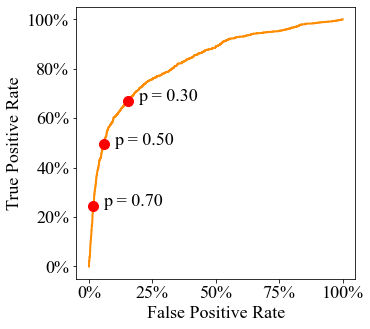

In [185]:
# Load the XGB predictions csvs
#true_predictions = pd.read_csv("xgb_true_predictions-YEAR-Separated.csv")
mcd_predictions = pd.read_csv("xgb_mcd_predictions-YEAR-Separated.csv")
mad_predictions = pd.read_csv("xgb_mad_predictions-YEAR-Separated.csv")
iqr_predictions = pd.read_csv("xgb_iqr_predictions-YEAR-Separated.csv")


# Create a ROC curve for each classification method from the prediction scores
#true_fpr, true_tpr, true_thresholds = metrics.roc_curve(true_predictions['HMTruth'], true_predictions['PredictionScore'])
mcd_fpr, mcd_tpr, mcd_thresholds = metrics.roc_curve(mcd_predictions['HMTruth'], mcd_predictions['PredictionScore'])
mad_fpr, mad_tpr, mad_thresholds = metrics.roc_curve(mad_predictions['HMTruth'], mad_predictions['PredictionScore'])
iqr_fpr, iqr_tpr, iqr_thresholds = metrics.roc_curve(iqr_predictions['HMTruth'], iqr_predictions['PredictionScore'])

#true_auc = metrics.auc(true_fpr, true_tpr)
mcd_auc = metrics.auc(mcd_fpr, mcd_tpr)
mad_auc = metrics.auc(mad_fpr, mad_tpr)
iqr_auc = metrics.auc(iqr_fpr, iqr_tpr)
#print(true_auc)
print(mcd_auc)
print(mad_auc)
print(iqr_auc)

# Plot the ROC curves

fig1 = plt.gcf()
fig = plt.figure(figsize=(5, 5))
#plt.plot(true_fpr, true_tpr, color='darkorange', lw=2, label=f'ROC curve (area = {true_auc:.2f})')
plt.plot(mcd_fpr, mcd_tpr, color='darkorange', lw=2, label=f'ROC curve (area = {mcd_auc:.2f})')
#plt.plot(mad_fpr, mad_tpr, color='darkorange', lw=2, label=f'ROC curve (area = {mad_auc:.2f})')
#plt.plot(iqr_fpr, iqr_tpr, color='darkorange', lw=2, label=f'ROC curve (area = {iqr_auc:.2f})')



# Find the tpr and fpr at the same index where rounded threshold = 0.5
index_05 = np.where(np.round(mcd_thresholds, 2) == 0.5)[0][0]
mcd_tpr_05 = mcd_tpr[index_05]
mcd_fpr_05 = mcd_fpr[index_05]
print(mcd_thresholds)
print(mcd_thresholds[index_05])
# plot a marker at the tpr and fpr where threshold = 0.5, set size of marker to 100
plt.plot(mcd_fpr_05, mcd_tpr_05, 'ro', markersize=10)
# Annotate the marker with the threshold value
plt.annotate('p = ' + f'{float(mcd_thresholds[index_05]):.2f}', (mcd_fpr_05, mcd_tpr_05),
             textcoords="offset points", xytext=(40,0), ha='center')

# Find the tpr and fpr at the same index where rounded threshold = 0.7
index_08 = np.where(np.round(mcd_thresholds, 2) == 0.7)[0][0]
mcd_tpr_08 = mcd_tpr[index_08]
mcd_fpr_08 = mcd_fpr[index_08]
# plot a marker at the tpr and fpr where threshold = 0.8, set size of marker to 100
plt.plot(mcd_fpr_08, mcd_tpr_08, 'ro', markersize=10)
# Annotate the marker with the threshold value
plt.annotate('p = ' + f'{float(mcd_thresholds[index_08]):.2f}', (mcd_fpr_08, mcd_tpr_08),
             textcoords="offset points", xytext=(40,0), ha='center')

# Find the tpr and fpr at the same index where rounded threshold = 0.3
index_03 = np.where(np.round(mcd_thresholds, 2) == 0.3)[0][0]
mcd_tpr_03 = mcd_tpr[index_03]
mcd_fpr_03 = mcd_fpr[index_03]
# plot a marker at the tpr and fpr where threshold = 0.3, set size of marker to 100
plt.plot(mcd_fpr_03, mcd_tpr_03, 'ro', markersize=10)
# Annotate the marker with the threshold value
plt.annotate('p = ' + f'{float(mcd_thresholds[index_03]):.2f}', (mcd_fpr_03, mcd_tpr_03),
             textcoords="offset points", xytext=(40,0), ha='center')


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Set all text to times new roman
plt.rcParams['font.family'] = 'Times New Roman'
# change the tick labels to percentage format
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'{x*100:.0f}%'))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'{x*100:.0f}%'))
# set font size to 12
plt.rcParams['font.size'] = 18

plt.show()

# Save the plot
fig.savefig('roc_curves-YEAR-Separated.svg', dpi=300, bbox_inches='tight')


Index(['RawID', 'HMTruth_x', 'Prediction', 'PredictionScore', 'HMTruth_y',
       'TreatmentID', 'HMMCD', 'NitrogenApplied', 'N2OFlux', 'last_fert',
       'NitrogenType_ESN', 'NitrogenType_Urea', 'NitrogenType_UAN', 'HMIQR',
       'HMMAD', 'ExperimentID', 'Group', 'VWC', 'SoilT'],
      dtype='object')


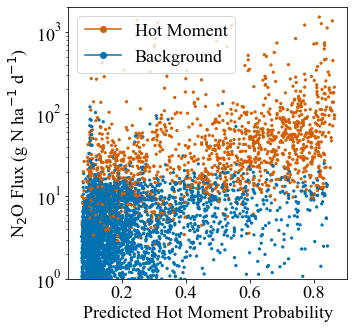

In [188]:
# Load the XGB predictions csvs
true_predictions = pd.read_csv("xgb_mcd_predictions-YEAR-Separated.csv")
Y = pd.read_csv("Y_all-YEAR_SEPARATED.csv")
# add the N2OFlux column from Y to true_predictions where RawID = RawID
true_predictions = true_predictions.merge(Y, on='RawID')
print(true_predictions.columns)
# Set font to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'
# Set font size to 12
plt.rcParams['font.size'] = 18

# Plot scatterplot of N2OFlux vs PredictionScore, set y axis to log scale, set hue to HMTruth
fig = plt.figure(figsize=(5, 5))
cmap = ['#0072b2', '#d55e00', ]
from matplotlib.colors import ListedColormap
cmap = ListedColormap(cmap)
plt.scatter(true_predictions['PredictionScore'], true_predictions['N2OFlux'], 
    c=true_predictions['HMTruth_x'], s=5, alpha=1, cmap=cmap)
plt.xlabel('Predicted Hot Moment Probability')
plt.ylabel('N$_{2}$O Flux (g N ha$^{-1}$ d$^{-1}$)')
plt.yscale('log')
# Set y axis limits
plt.ylim(1, 2000)
# Add items to legend, red = Hot Moment, blue = Background, use circle markers, use seismic color map 
plt.legend(handles=[plt.Line2D([0], [0], color='#d55e00', marker='o', markerfacecolor='#d55e00'), 
    plt.Line2D([0], [0], color='#0072b2', marker='o', markerfacecolor='#0072b2')], 
    labels=['Hot Moment', 'Background'], loc='upper left')

# Save the plot as svg
plt.savefig('N2OFlux_vs_PredictionScore-YEAR-Separated.svg', dpi=300, bbox_inches='tight')

plt.show()




In [191]:
# Load the rf predictions csvs
true_predictions = pd.read_csv("xgb_true_predictions-YEAR-Separated.csv")
mcd_predictions = pd.read_csv("xgb_mcd_predictions-YEAR-Separated.csv")
mad_predictions = pd.read_csv("xgb_mad_predictions-YEAR-Separated.csv")
iqr_predictions = pd.read_csv("xgb_iqr_predictions-YEAR-Separated.csv")

# Connect to mysql database
cnx = mysql.connector.connect(user='root', password='Kh18riku!',
                                host='127.0.0.1',
                                database='global_n2o')
cursor = cnx.cursor()

query = ("SELECT * FROM RawClassificationTreatment")
# Execute the query and fetch all results
alldata = pd.read_sql(query, cnx)
cnx.close()
# Starting with -5 and ending with 50, create bins of width 5. Find the percent of correct predictions in each bin
bin_edges = np.arange(-5, 51, 5)
bin_centers = bin_edges[:-1] + 2.5
# Create a new bin edge and center for all data above 50
bin_edges = np.append(bin_edges, 5000)
bin_centers = np.append(bin_centers, 52.5)
# Assign a bin to each N2OFlux value
alldata['Bin'] = pd.cut(alldata['N2OFlux'], bins=bin_edges, labels=bin_centers)
print(alldata['Bin'].value_counts())


# Add the N2OFlux columns to the predictions dataframes, merge on RawID
true_predictions = pd.merge(true_predictions, alldata[['RawID', 'N2OFlux', 'Bin']], on='RawID')
mcd_predictions = pd.merge(mcd_predictions, alldata[['RawID', 'N2OFlux', 'Bin']], on='RawID')
mad_predictions = pd.merge(mad_predictions, alldata[['RawID', 'N2OFlux', 'Bin']], on='RawID')
iqr_predictions = pd.merge(iqr_predictions, alldata[['RawID', 'N2OFlux', 'Bin']], on='RawID')

publications = pd.merge(iqr_predictions, alldata[['RawID', 'N2OFlux', 'PubID']], on='RawID')
# Print the number of unique publications

print(publications['PubID'].nunique())
print(publications['PubID'].unique)

# Drop rows without bins
true_predictions = true_predictions.dropna(subset=['Bin'])
mcd_predictions = mcd_predictions.dropna(subset=['Bin'])
mad_predictions = mad_predictions.dropna(subset=['Bin'])
iqr_predictions = iqr_predictions.dropna(subset=['Bin'])
alldata = alldata.dropna(subset=['Bin'])
# Add a new column to which =1 if the prediction is correct and 0 if the prediction is incorrect
true_predictions['Correct'] = np.where(true_predictions['HMTruth'] == true_predictions['Prediction'], 1, 0)
mcd_predictions['Correct'] = np.where(mcd_predictions['HMTruth'] == mcd_predictions['Prediction'], 1, 0)
mad_predictions['Correct'] = np.where(mad_predictions['HMTruth'] == mad_predictions['Prediction'], 1, 0)
iqr_predictions['Correct'] = np.where(iqr_predictions['HMTruth'] == iqr_predictions['Prediction'], 1, 0)
# Create column for type of errors. 1 = type 1 error, 2 = type 2 error
true_predictions['ErrorType'] = np.where((true_predictions['HMTruth'] == 0) & (true_predictions['Prediction'] == 1), 1, 0)
true_predictions['ErrorType'] = np.where((true_predictions['HMTruth'] == 1) & (true_predictions['Prediction'] == 0), 2, true_predictions['ErrorType'])
mcd_predictions['ErrorType'] = np.where((mcd_predictions['HMTruth'] == 0) & (mcd_predictions['Prediction'] == 1), 1, 0)
mcd_predictions['ErrorType'] = np.where((mcd_predictions['HMTruth'] == 1) & (mcd_predictions['Prediction'] == 0), 2, mcd_predictions['ErrorType'])
mad_predictions['ErrorType'] = np.where((mad_predictions['HMTruth'] == 0) & (mad_predictions['Prediction'] == 1), 1, 0)
mad_predictions['ErrorType'] = np.where((mad_predictions['HMTruth'] == 1) & (mad_predictions['Prediction'] == 0), 2, mad_predictions['ErrorType'])
iqr_predictions['ErrorType'] = np.where((iqr_predictions['HMTruth'] == 0) & (iqr_predictions['Prediction'] == 1), 1, 0)
iqr_predictions['ErrorType'] = np.where((iqr_predictions['HMTruth'] == 1) & (iqr_predictions['Prediction'] == 0), 2, iqr_predictions['ErrorType'])

# Create a dataframe tracking the classification method, bin, and error types/rates
error_df = pd.DataFrame(columns=['Classification', 'Bin', 'TP', 'FP', 'TN', 'FN'])
df_list = [true_predictions, mcd_predictions, mad_predictions, iqr_predictions]
classification_list = ['True', 'MCD', 'MAD', 'IQR']
i=0
for classification in df_list:
    # For each bin, find the percent of correct predictions and incorrect predictions
    for bin in alldata['Bin'].unique():
        print(bin)
        # Get only the rows in the correct bin
        bindf = classification[classification['Bin'] == bin]
        print(bindf.head())
        tp_percent = len(bindf[(bindf['Correct'] == 1) & (bindf['HMTruth'] == 1)].index) / len(bindf.index)
        fp_percent = len(bindf[(bindf['Correct'] == 0) & (bindf['HMTruth'] == 0)].index) / len(bindf.index)
        tn_percent = len(bindf[(bindf['Correct'] == 1) & (bindf['HMTruth'] == 0)].index) / len(bindf.index)
        fn_percent = len(bindf[(bindf['Correct'] == 0) & (bindf['HMTruth'] == 1)].index) / len(bindf.index)
        error_df = error_df.append({'Classification': classification_list[i], 'Bin': bin, 'TP': tp_percent, 'FP': fp_percent, 'TN': tn_percent, 'FN': fn_percent}, ignore_index=True)
    i=i+1

# Save error_df to a CSV
error_df.to_csv('error_df-YEAR_Separated.csv', index=False)


/home/ryan/.virtualenv/time/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



2.5     14059
7.5      3435
12.5     1748
52.5      979
17.5      850
-2.5      703
22.5      502
27.5      346
32.5      253
42.5      168
37.5      161
47.5      128
Name: Bin, dtype: int64
19
<bound method Series.unique of 0       32
1       32
2       32
3       32
4       32
        ..
6113    57
6114    57
6115    57
6116    57
6117    57
Name: PubID, Length: 6118, dtype: int64>
42.5
      RawID  HMTruth  Prediction  N2OFlux   Bin  Correct  ErrorType
555  194498      1.0           1  41.2432  42.5        1          0
742  113413      1.0           0  42.7561  42.5        0          2
783  114272      1.0           0  43.8680  42.5        0          2
870  116868      1.0           0  43.1103  42.5        0          2
871  116870      1.0           0  41.4379  42.5        0          2
-2.5
      RawID  HMTruth  Prediction   N2OFlux  Bin  Correct  ErrorType
313  175767      0.0           0 -0.024958 -2.5        1          0
328  175868      0.0           0 -0.005663 -2.5        1  

/tmp/ipykernel_4306/2063373819.py:77: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_4306/2063373819.py:77: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_4306/2063373819.py:77: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_4306/2063373819.py:77: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_4306/2063373819.py:77: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_4306/2063373819.py:77: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future

    RawID  HMTruth  Prediction  PredictionScore  N2OFlux   Bin  Correct  \
0   74821      0.0           0         0.192378  14.8000  12.5        1   
1   74827      0.0           0         0.189575  10.6362  12.5        1   
3   74854      0.0           0         0.171798  11.9150  12.5        1   
4   74872      0.0           0         0.217653  11.0463  12.5        1   
10  74952      0.0           0         0.165801  14.3313  12.5        1   

    ErrorType  
0           0  
1           0  
3           0  
4           0  
10          0  
47.5
      RawID  HMTruth  Prediction  PredictionScore  N2OFlux   Bin  Correct  \
36    77106      1.0           0         0.192624  48.7575  47.5        0   
174  163944      1.0           0         0.157747  45.5207  47.5        0   
733  113390      1.0           1         0.626149  45.1902  47.5        1   
782  114270      1.0           1         0.600189  49.5890  47.5        1   
821  115988      1.0           1         0.626149  48.9699  47.

/tmp/ipykernel_4306/2063373819.py:77: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_4306/2063373819.py:77: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_4306/2063373819.py:77: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_4306/2063373819.py:77: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_4306/2063373819.py:77: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_4306/2063373819.py:77: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future

     RawID  HMTruth  Prediction  PredictionScore  N2OFlux   Bin  Correct  \
18   75003      0.0           0         0.286748  15.0238  17.5        1   
21   75040      0.0           0         0.054301  16.3088  17.5        1   
79   94549      1.0           0         0.107967  19.7815  17.5        0   
118  98811      1.0           0         0.076083  16.8407  17.5        0   
133  99669      1.0           0         0.149330  15.3951  17.5        0   

     ErrorType  
18           0  
21           0  
79           2  
118          2  
133          2  
27.5
      RawID  HMTruth  Prediction  PredictionScore  N2OFlux   Bin  Correct  \
25    76949      1.0           0         0.147926  29.8950  27.5        0   
115   98803      1.0           0         0.206810  28.4558  27.5        0   
163  163908      1.0           0         0.222041  29.0025  27.5        0   
175  163950      1.0           0         0.056053  27.1892  27.5        0   
211  165510      1.0           0         0.447954  

/tmp/ipykernel_4306/2063373819.py:77: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_4306/2063373819.py:77: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_4306/2063373819.py:77: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_4306/2063373819.py:77: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_4306/2063373819.py:77: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [192]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# Create a histogram of the percent of correct predictions and incorrect predictions for each bin
error_df = pd.read_csv("error_df-YEAR_Separated.csv")

# Create a 2 by 2 grid of subplots
fig = make_subplots(rows=2, cols=2, subplot_titles=('True', 'MCD', 'MAD', 'IQR'), horizontal_spacing = 0.02, vertical_spacing = 0.1)
classification_list = ['True', 'MCD', 'MAD', 'IQR']

# Add a stacked bar chart to each subplot
k=0
for i in np.arange(2):
    for j in np.arange(2):
        bins_list = error_df[error_df['Classification'] == classification_list[k]]['Bin'].tolist()
        tp_list = error_df[error_df['Classification'] == classification_list[k]]['TP'].tolist()
        tn_list = error_df[error_df['Classification'] == classification_list[k]]['TN'].tolist()
        fp_list = error_df[error_df['Classification'] == classification_list[k]]['FP'].tolist()
        fn_list = error_df[error_df['Classification'] == classification_list[k]]['FN'].tolist()

        fig.add_bar(x=bins_list, y=fn_list, name='False Negatives', row=i+1, col=j+1, marker=dict(color='darkred'))
        fig.add_bar(x=bins_list, y=fp_list, name='False Positives', row=i+1, col=j+1, marker=dict(color='red'))
        fig.add_bar(x=bins_list, y=tn_list, name='True Negatives', row=i+1, col=j+1, marker=dict(color='green'))
        fig.add_bar(x=bins_list, y=tp_list, name='True Positives', row=i+1, col=j+1, marker=dict(color='seagreen'))
        fig.update_layout(barmode='stack', title_text=classification_list[i], )
        # Set the subplot
        fig.update_xaxes(title_text='Bin', row=i+1, col=j+1)
        fig.update_yaxes(title_text='Percentage', row=i+1, col=j+1)
        k=k+1
        # if i or j > 0, update the trace to remove the legend
        if i > 0 or j > 0:
            fig.update_traces(showlegend=False, row=i+1, col=j+1)
# Set y tick labels manually
fig.update_yaxes(tickvals=[0,0.2,0.4, 0.6, 0.8, 1.0], row=1, col=1)
fig.update_yaxes(tickvals=[0,0.2,0.4, 0.6, 0.8, 1.0], row=1, col=2, ticktext=['', '', '', '', '', ''])
fig.update_yaxes(tickvals=[0,0.2,0.4, 0.6, 0.8, 1.0], row=2, col=1)
fig.update_yaxes(tickvals=[0,0.2,0.4, 0.6, 0.8, 1.0], row=2, col=2, ticktext=['', '', '', '', '', ''])
# Set Y axis tick labels to percents
fig.update_yaxes(tickformat=".0%", row=1, col=1)
fig.update_yaxes(tickformat=".0%", row=1, col=2)
fig.update_yaxes(tickformat=".0%", row=2, col=1)
fig.update_yaxes(tickformat=".0%", row=2, col=2)
# Set y axis titles
fig.update_yaxes(title_text='Percentage', row=1, col=1)
fig.update_yaxes(title_text='', row=1, col=2)
fig.update_yaxes(title_text='Percentage', row=2, col=1)
fig.update_yaxes(title_text='', row=2, col=2)
# Set x axis labels
fig.update_xaxes(title_text='', row=1, col=1)
fig.update_xaxes(title_text='', row=1, col=2)
fig.update_xaxes(title_text='Flux', row=2, col=1)
fig.update_xaxes(title_text='Flux', row=2, col=2)
# Set x tick labels manually
x_labels = ['< 0', '0-5', '5-10', '10-15', '15-20', '20-25', '25-30', '30-35', '35-40', '40-45', '45-50', '> 50']
blank_labels = ['', '', '', '', '', '', '', '', '', '', '', '']
fig.update_xaxes(tickvals = [-2.5, 2.5, 7.5, 12.5, 17.5, 22.5, 27.5, 32.5, 37.5, 42.5, 47.5, 52.5], ticktext=blank_labels, row=1, col=1)
fig.update_xaxes(tickvals = [-2.5, 2.5, 7.5, 12.5, 17.5, 22.5, 27.5, 32.5, 37.5, 42.5, 47.5, 52.5], ticktext=blank_labels, row=1, col=2)
fig.update_xaxes(tickvals = [-2.5, 2.5, 7.5, 12.5, 17.5, 22.5, 27.5, 32.5, 37.5, 42.5, 47.5, 52.5], ticktext=x_labels, row=2, col=1)
fig.update_xaxes(tickvals = [-2.5, 2.5, 7.5, 12.5, 17.5, 22.5, 27.5, 32.5, 37.5, 42.5, 47.5, 52.5], ticktext=x_labels, row=2, col=2)
# Set figure title
fig.update_layout(title_text='', title_x=0.5)
# Set figure style
fig.update_layout(
    template="plotly_white",
)
fig.show()

# Save the figure
fig.write_image("error_df-YEAR_Separated.svg", format='svg')

In [193]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# Create the same figure as above, but only for the RF model using true classifications
error_df = pd.read_csv("error_df-YEAR_Separated.csv")
bins_list = error_df[error_df['Classification'] == 'MCD']['Bin'].tolist()
tp_list = error_df[error_df['Classification'] == 'MCD']['TP'].tolist()
fp_list = error_df[error_df['Classification'] == 'MCD']['FP'].tolist()
tn_list = error_df[error_df['Classification'] == 'MCD']['TN'].tolist()
fn_list = error_df[error_df['Classification'] == 'MCD']['FN'].tolist()

fig = make_subplots(rows=1, cols=1)
# Set figure size
fig.update_layout(width=1000, height=500)

fig.add_bar(x=bins_list, y=fn_list, name='False Negatives', row=1, col=1, marker=dict(color='#d55e00'))
fig.add_bar(x=bins_list, y=fp_list, name='False Positives', row=1, col=1, marker=dict(color='#f0e442'))
fig.add_bar(x=bins_list, y=tn_list, name='True Negatives', row=1, col=1, marker=dict(color='#0072b2'))
fig.add_bar(x=bins_list, y=tp_list, name='True Positives', row=1, col=1, marker=dict(color='#009e73'))
fig.update_layout(barmode='stack', title_text='', )
# Set the subplot
fig.update_xaxes(title_text='N<sub>2</sub>O Flux (g N ha<sup>-1</sup> d<sup>-1</sup>)', row=1, col=1)
#fig.update_yaxes(title_text='Percentage', row=1, col=1)
# Set y tick labels manually
fig.update_yaxes(tickvals=[0,0.2,0.4, 0.6, 0.8, 1.0], row=1, col=1)
# Set Y axis tick labels to percents
fig.update_yaxes(tickformat=".0%", row=1, col=1)

# Set x tick labels manually
x_labels = ['< 0', '0-5', '5-10', '10-15', '15-20', '20-25', '25-30', '30-35', '35-40', '40-45', '45-50', '> 50']
fig.update_xaxes(tickvals = [-2.5, 2.5, 7.5, 12.5, 17.5, 22.5, 27.5, 32.5, 37.5, 42.5, 47.5, 52.5], ticktext=x_labels, row=1, col=1)
# Set all font to my_font
fig.update_layout(
    font_family="Times New Roman",
    font_color="black",
    title_font_family="Times New Roman",
    legend_title_font_color="black",
    legend_font_size=20,
    xaxis_tickfont_size=20,
    yaxis_tickfont_size=20,
    xaxis_title_font_size=30,
    yaxis_title_font_size=30
)
# Set y axis title
fig.update_yaxes(title_text='Percentage of Measurements', row=1, col=1)


# Set figure style
fig.update_layout(
    template="plotly_white",
)
fig.write_image("XGB_error_fig.svg", format='svg',)

fig.show()




In [238]:
import pickle
# Load RF model
filename = 'XGB_classification_model.sav'
RF_classifier = pickle.load(open(filename, 'rb'))
X = pd.read_csv("X_all.csv")
X = X.drop(['TreatmentID', 'RawID', 'last_fert_type',], axis = 1)
Y = pd.read_csv("Y_all.csv")

In [158]:
# Prin value counts of X['Category']
print(X['Category'].value_counts())
print(X['Category2'].value_counts())
print(X.columns)

Background    5226
SummerHM      1011
SpringHM       386
FallHM         105
WinterHM        25
Name: Category, dtype: int64
Background     5226
InseasonHM     1298
OffseasonHM     229
Name: Category2, dtype: int64
Index(['DOY', 'VWC', 'SoilT', 'Precip', 'SandMean', 'SiltMean', 'ClayMean',
       'MAP', 'MAT', 'Latitude', 'Longitude', 'days_since_precip',
       'last_precip', 'days_since_fert', 'last_fert', 'vwc_dm1', 'vwc_dm2',
       'vwc_dm3', 'vwc_dm4', 'vwc_dm5', 'vwc_dm6', 'vwc_dm7', 'precip_dm1',
       'precip_dm2', 'precip_dm3', 'precip_dm4', 'precip_dm5', 'precip_dm6',
       'precip_dm7', 'soilT_dm1', 'soilT_dm2', 'soilT_dm3', 'soilT_dm4',
       'soilT_dm5', 'soilT_dm6', 'soilT_dm7', 'VWC_rollingmean',
       'SoilT_rollingmean', 'NitrogenType_Ammonia',
       'NitrogenType_Ammonium Nitrate', 'NitrogenType_Ammonium Phosphate',
       'NitrogenType_Anhydrous Ammonia', 'NitrogenType_Cover Crop',
       'NitrogenType_ESN', 'NitrogenType_Manure', 'NitrogenType_UAN',
       'Nit

In [239]:
# Graph feature importance
import matplotlib.pyplot as plt
from xgboost import plot_importance
import shap

In [240]:
# build a clustering of the features based on shared information about y
clustering = shap.utils.hclust(X.drop(['Category', 'Category2'], axis = 1), Y['HMTruth'])

# above we implicitly used shap.maskers.Independent by passing a raw dataframe as the masker
# now we explicitly use a Partition masker that uses the clustering we just computed
masker = shap.maskers.Partition(X.drop(['Category', 'Category2'], axis = 1), clustering=clustering)

# build an Exact explainer and explain the model predictions on the given dataset
explainer = shap.explainers.Permutation(RF_classifier.predict_proba, masker)
shap_values2 = explainer(X.drop(['Category', 'Category2'], axis = 1))

 58%|█████▊    | 40/69 [17:56<07:49, 16.18s/it]  /home/ryan/anaconda3/lib/python3.9/site-packages/shap/utils/_clustering.py:126: UserWarning:

No/low signal found from feature 39 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).

/home/ryan/anaconda3/lib/python3.9/site-packages/shap/utils/_clustering.py:126: UserWarning:

No/low signal found from feature 40 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).

 62%|██████▏   | 43/69 [18:10<04:11,  9.66s/it]/home/ryan/anaconda3/lib/python3.9/site-packages/shap/utils/_clustering.py:126: UserWarning:

No/low signal found from feature 42 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).

/home/ryan/anaconda3/lib/python3.9/site-packages/shap/utils/_clustering.py:126: UserW

In [242]:
import pickle

# Save  shap values
with open('xgb_shap_values.pkl', 'wb') as f:
    pickle.dump(shap_values2, f)

In [243]:
print(X.drop(['Category', 'Category2'], axis = 1).columns)

Index(['DOY', 'VWC', 'SoilT', 'Precip', 'SandMean', 'SiltMean', 'ClayMean',
       'MAP', 'MAT', 'Latitude', 'Longitude', 'days_since_precip',
       'last_precip', 'days_since_fert', 'last_fert', 'vwc_dm1', 'vwc_dm2',
       'vwc_dm3', 'vwc_dm4', 'vwc_dm5', 'vwc_dm6', 'vwc_dm7', 'precip_dm1',
       'precip_dm2', 'precip_dm3', 'precip_dm4', 'precip_dm5', 'precip_dm6',
       'precip_dm7', 'soilT_dm1', 'soilT_dm2', 'soilT_dm3', 'soilT_dm4',
       'soilT_dm5', 'soilT_dm6', 'soilT_dm7', 'VWC_rollingmean',
       'SoilT_rollingmean', 'NitrogenType_Ammonia',
       'NitrogenType_Ammonium Nitrate', 'NitrogenType_Ammonium Phosphate',
       'NitrogenType_Anhydrous Ammonia', 'NitrogenType_Cover Crop',
       'NitrogenType_ESN', 'NitrogenType_Manure', 'NitrogenType_UAN',
       'NitrogenType_Unknown', 'NitrogenType_Urea',
       'PrimaryCrop_Allium fistulosum (Onion)', 'PrimaryCrop_Corn, Cowpea',
       'PrimaryCrop_Cotton', 'PrimaryCrop_Glycine max (Soybean)',
       'PrimaryCrop_Hordeum vul

/tmp/ipykernel_5780/361584625.py:14: MatplotlibDeprecationWarning:

Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.

/tmp/ipykernel_5780/361584625.py:17: UserWarning:

FixedFormatter should only be used together with FixedLocator



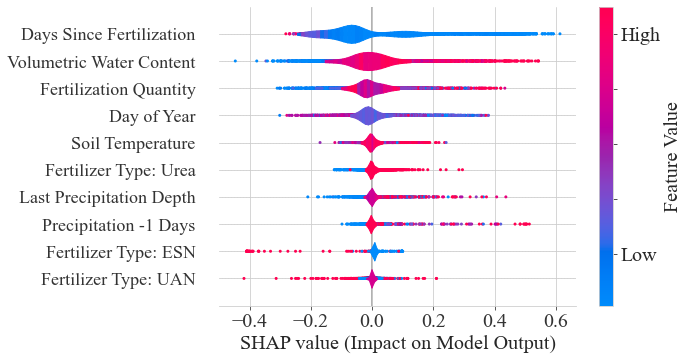

In [299]:
main_features = [0, 1, 2,  12, 13, 14, 22, 43, 45, 47]
feat_names = ['Day of Year', 'Volumetric Water Content', 'Soil Temperature',   'Last Precipitation Depth', 'Days Since Fertilization', 'Fertilization Quantity', 'Precipitation -1 Days', 'Fertilizer Type: ESN', 'Fertilizer Type: UAN', 'Fertilizer Type: Urea']
shap.plots.violin(shap_values2[:,main_features,1], max_display=16,  show=False, feature_names=feat_names, color_bar=False)
# Set tick label font
plt.rc('font', family='Times New Roman')
# Set x axis font size
plt.xticks(fontsize=20)
plt.xlabel(xlabel='SHAP value (Impact on Model Output)', fontsize=20)

# Set y axis font size
plt.yticks(fontsize=18)

# Set shap color bar font
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)
##### Set cbar tick labels
cbar.ax.set_yticklabels(['','Low', '','','', 'High'])

# Set colorbar labels
cbar.ax.set_ylabel('Feature Value', fontsize=20)
# Set font to Times New Roman
plt.rc('font', family='Times New Roman')


plt.savefig('all_shap_violin.svg', bbox_inches = 'tight', pad_inches = 0.1, dpi = 800)

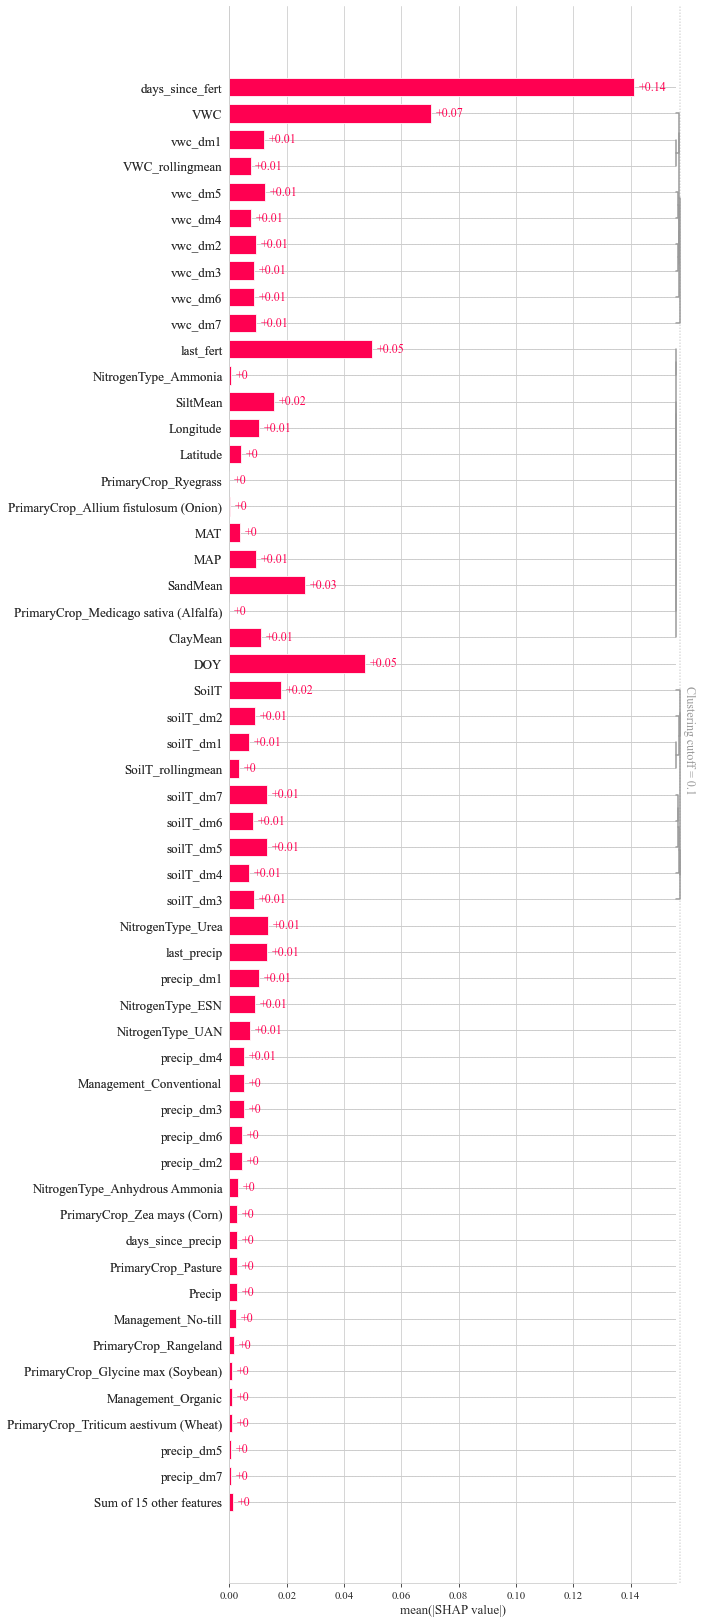

In [292]:
shap.plots.bar(shap_values2[:,:,1], max_display=55, clustering_cutoff=0.1)
# save the figure

In [170]:
# Get the indexes of X where Category is Inseason
inseason = X[X['Category2'] == 'InseasonHM'].drop(['Category', 'Category2'], axis = 1)
inseason_index = X[X['Category2'] == 'InseasonHM'].index

# Get the shap values for Inseason HM
inseason_shap = shap_values2[inseason_index]
# Get the feature names
feat_names = list(inseason.columns)

shap.plots.violin(inseason_shap[:,:,1], feature_names=feat_names, features=inseason, max_display=15,  show=False)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

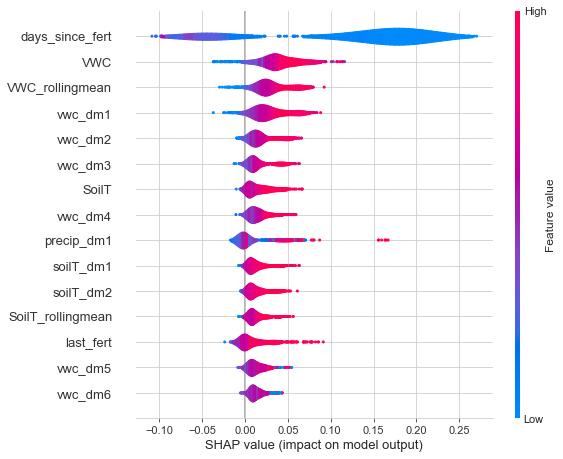

In [150]:
# Get the indexes of X where Category is Summer
summer = X[X['Category'] == 'SummerHM'].drop(['Category'], axis = 1)
summer_index = X[X['Category'] == 'SummerHM'].index

# Get the shap values for Inseason HM
summer_shap = shap_values[summer_index]
# Get the feature names
feat_names = list(summer.columns)

shap.plots.violin(summer_shap[:,:,1], feature_names=feat_names, features=summer, max_display=15,  show=False)
# Save plot
plt.savefig("summer_summary_plot.svg", format='svg', bbox_inches='tight')

/tmp/ipykernel_212108/3604219207.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fall_winter = fall_winter.append(X[X['Category'] == 'WinterHM'].drop(['Category'], axis = 1))


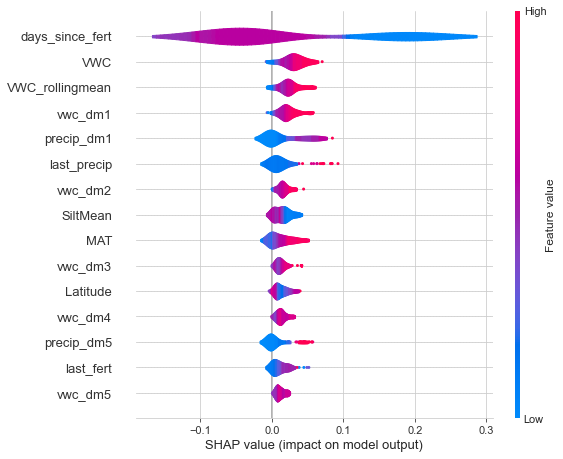

In [166]:
# Get the shap values for Fall or winter HM
fall_winter = X[X['Category'] == 'FallHM'].drop(['Category'], axis = 1)
fall_winter = fall_winter.append(X[X['Category'] == 'WinterHM'].drop(['Category'], axis = 1))
fall_winter_index = X[X['Category'] == 'FallHM'].index
fall_winter_index = fall_winter_index.append(X[X['Category'] == 'WinterHM'].index)


# Get the shap values for Spring HM
fall_shap = shap_values[fall_winter_index]
feat_names = list(fall_winter.columns)

shap.plots.violin(fall_shap[:,:,1], feature_names=feat_names, features=fall_winter, max_display=15,  show=False)

In [282]:
# Load X and Y data
true_predictions = pd.read_csv("xgb_true_predictions.csv")
X = pd.read_csv("X_plus.csv")
# Connect to mysql database
cnx = mysql.connector.connect(user='root', password='Kh18riku!',
                                host='127.0.0.1',
                                database='global_n2o')
cursor = cnx.cursor()

query = ("SELECT * FROM RawClassificationTreatment")
# Execute the query and fetch all results
alldata = pd.read_sql(query, cnx)
cnx.close()
alldata = pd.merge(true_predictions, alldata[['RawID', 'N2OFlux', 'VWC', 'SoilT']], on='RawID')
alldata = pd.merge(alldata, X[['RawID', 'days_since_fert']], on='RawID')
print(alldata.head())

# Create for both VWC and Days Since Fertilization. Find the percent of hot moments in the intersection of each bin
vwc_bin_edges = np.arange(0.05, 0.56, 0.05)
vwc_bin_centers = vwc_bin_edges[:-1] + 0.05
fert_bin_edges = np.arange(0, 81, 10)
fert_bin_centers = fert_bin_edges[:-1] + 5
vwc_fert_df = pd.DataFrame(columns=['VWC', 'DaysSinceFert', 'HM_Percentage', 'n'])
for i in np.arange(len(vwc_bin_centers)):
    for j in np.arange(len(fert_bin_centers)):
        hm = len(alldata.query('VWC >= @vwc_bin_edges[@i] and VWC < @vwc_bin_edges[@i+1] and days_since_fert >= @fert_bin_edges[@j] and days_since_fert < @fert_bin_edges[@j+1] and Prediction == 1'))
        total = len(alldata.query('VWC >= @vwc_bin_edges[@i] and VWC < @vwc_bin_edges[@i+1] and days_since_fert >= @fert_bin_edges[@j] and days_since_fert < @fert_bin_edges[@j+1]'))
        if total == 0:
            vwc_fert_df = vwc_fert_df.append({'VWC': vwc_bin_centers[i], 'DaysSinceFert': fert_bin_centers[j], 'HM_Percentage': -0.1,
                                              'n': ' '}, ignore_index=True)
        else:
            vwc_fert_df = vwc_fert_df.append({'VWC': vwc_bin_centers[i], 'DaysSinceFert': fert_bin_centers[j], 'HM_Percentage': hm / total,
                                              'n': total}, ignore_index=True)

# Save df
vwc_fert_df.to_csv("vwc_fert_df.csv", index=False)

/home/ryan/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



   RawID  HMTruth  Prediction  PredictionScore    N2OFlux  VWC    SoilT  \
0    665      0.0           0              0.0  12.889000  NaN  20.2077   
1    667      0.0           0              0.0   4.059610  NaN  18.4867   
2    674      0.0           0              0.0  14.718300  NaN  22.0147   
3    765      0.0           0              0.0   0.009045  NaN      NaN   
4    776      0.0           0              0.0  -0.628807  NaN      NaN   

   days_since_fert  
0             10.0  
1             12.0  
2             19.0  
3             11.0  
4             22.0  


/tmp/ipykernel_5780/3331203765.py:32: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_5780/3331203765.py:32: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_5780/3331203765.py:32: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_5780/3331203765.py:32: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_5780/3331203765.py:32: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_5780/3331203765.py:32: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future

In [283]:
# Load X and Y data
true_predictions = pd.read_csv("xgb_true_predictions.csv")
# Connect to mysql database
cnx = mysql.connector.connect(user='root', password='Kh18riku!',
                                host='127.0.0.1',
                                database='global_n2o')
cursor = cnx.cursor()

query = ("SELECT * FROM RawClassificationTreatment")
# Execute the query and fetch all results
alldata = pd.read_sql(query, cnx)
cnx.close()
alldata = pd.merge(true_predictions, alldata[['RawID', 'N2OFlux', 'VWC', 'SoilT']], on='RawID')
print(alldata.head())

# Create for both VWC and SoilT. Find the percent of hot moments in the intersection of each bin
vwc_bin_edges = np.arange(0.05, 0.56, 0.05)
vwc_bin_centers = vwc_bin_edges[:-1] + 0.05
soilT_bin_edges = np.arange(0, 31, 5)
soilT_bin_centers = soilT_bin_edges[:-1] + 2.5
vwc_soilT_df = pd.DataFrame(columns=['VWC', 'SoilT', 'HM_Percentage', 'n'])
print(np.arange(len(soilT_bin_centers) - 1))
for i in np.arange(len(vwc_bin_edges) - 1):
    for j in np.arange(len(soilT_bin_edges) - 1):
        hm = len(alldata.query('VWC >= @vwc_bin_edges[@i] and VWC < @vwc_bin_edges[@i+1] and SoilT >= @soilT_bin_edges[@j] and SoilT < @soilT_bin_edges[@j+1] and Prediction == 1'))
        total = len(alldata.query('VWC >= @vwc_bin_edges[@i] and VWC < @vwc_bin_edges[@i+1] and SoilT >= @soilT_bin_edges[@j] and SoilT < @soilT_bin_edges[@j+1]'))
        if total == 0:
            vwc_soilT_df = vwc_soilT_df.append({'VWC': vwc_bin_centers[i], 'SoilT': soilT_bin_centers[j], 'HM_Percentage': -0.1,
                                               'n': ' '}, ignore_index=True)
        else:
            vwc_soilT_df = vwc_soilT_df.append({'VWC': vwc_bin_centers[i], 'SoilT': soilT_bin_centers[j], 'HM_Percentage': hm / total,
                                               'n': total}, ignore_index=True)

# Save df
vwc_soilT_df.to_csv("vwc_soilT_df.csv", index=False)

# Load X and Y data
true_predictions = pd.read_csv("xgb_true_predictions.csv")


# Connect to mysql database
cnx = mysql.connector.connect(user='root', password='Kh18riku!',
                                host='127.0.0.1',
                                database='global_n2o')
cursor = cnx.cursor()

query = ("SELECT * FROM RawClassificationTreatment")
# Execute the query and fetch all results
alldata = pd.read_sql(query, cnx)
cnx.close()
alldata = pd.merge(true_predictions, alldata[['RawID', 'N2OFlux', 'VWC', 'SoilT']], on='RawID')
print(alldata.head())

# Create for both VWC and SoilT. Find the percent of hot moments in the intersection of each bin
vwc_bin_edges = np.arange(0.05, 0.56, 0.05)
vwc_bin_centers = vwc_bin_edges[:-1] + 0.05
soilT_bin_edges = np.arange(0, 31, 5)
soilT_bin_centers = soilT_bin_edges[:-1] + 2.5
vwc_soilT_df = pd.DataFrame(columns=['VWC', 'SoilT', 'HM_Percentage', 'n'])
print(np.arange(len(soilT_bin_centers) - 1))
for i in np.arange(len(vwc_bin_edges) - 1):
    for j in np.arange(len(soilT_bin_edges) - 1):
        hm = len(alldata.query('VWC >= @vwc_bin_edges[@i] and VWC < @vwc_bin_edges[@i+1] and SoilT >= @soilT_bin_edges[@j] and SoilT < @soilT_bin_edges[@j+1] and Prediction == 1'))
        total = len(alldata.query('VWC >= @vwc_bin_edges[@i] and VWC < @vwc_bin_edges[@i+1] and SoilT >= @soilT_bin_edges[@j] and SoilT < @soilT_bin_edges[@j+1]'))
        if total == 0:
            vwc_soilT_df = vwc_soilT_df.append({'VWC': vwc_bin_centers[i], 'SoilT': soilT_bin_centers[j], 'HM_Percentage': -0.1,
                                               'n': ' '}, ignore_index=True)
        else:
            vwc_soilT_df = vwc_soilT_df.append({'VWC': vwc_bin_centers[i], 'SoilT': soilT_bin_centers[j], 'HM_Percentage': hm / total,
                                               'n': total}, ignore_index=True)

# Save df
vwc_soilT_df.to_csv("vwc_soilT_df.csv", index=False)# Load X and Y data


/home/ryan/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



   RawID  HMTruth  Prediction  PredictionScore    N2OFlux  VWC    SoilT
0    665      0.0           0              0.0  12.889000  NaN  20.2077
1    667      0.0           0              0.0   4.059610  NaN  18.4867
2    674      0.0           0              0.0  14.718300  NaN  22.0147
3    765      0.0           0              0.0   0.009045  NaN      NaN
4    776      0.0           0              0.0  -0.628807  NaN      NaN
[0 1 2 3 4]


/tmp/ipykernel_5780/1010598473.py:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_5780/1010598473.py:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_5780/1010598473.py:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_5780/1010598473.py:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_5780/1010598473.py:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_5780/1010598473.py:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future

   RawID  HMTruth  Prediction  PredictionScore    N2OFlux  VWC    SoilT
0    665      0.0           0              0.0  12.889000  NaN  20.2077
1    667      0.0           0              0.0   4.059610  NaN  18.4867
2    674      0.0           0              0.0  14.718300  NaN  22.0147
3    765      0.0           0              0.0   0.009045  NaN      NaN
4    776      0.0           0              0.0  -0.628807  NaN      NaN
[0 1 2 3 4]


/tmp/ipykernel_5780/1010598473.py:69: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_5780/1010598473.py:69: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_5780/1010598473.py:69: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_5780/1010598473.py:69: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_5780/1010598473.py:69: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_5780/1010598473.py:69: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future

In [284]:
# Load X
X = pd.read_csv("X_plus.csv")
# Load true predictions
true_predictions = pd.read_csv("xgb_true_predictions.csv")
# Merge X with predictions
alldata = pd.merge(true_predictions, X, on='RawID')
# Drop rows where Prediction is null
alldata = alldata.dropna(subset=['Prediction'])
# Rename 'Ammonia'  to 'Anhydrous Ammonia'
alldata['last_fert_type'] = alldata['last_fert_type'].replace('Ammonia', 'Anhydrous Ammonia')

# Create bins for days since fert
days_since_fert_bin_edges = np.arange(0, 81, 10)
days_since_fert_bin_centers = days_since_fert_bin_edges[:-1] + 5
fert_model_df = pd.DataFrame(columns=['DaysSinceFert', 'FertType' , 'HM_Percentage', 'n'])

# For each unique value in LastFertType whith value count above 1000, iterate through each bin of days since fert and calculate the HM_Percentage
# Rename 'Ammonia' and 'Ammonium Phosphate' to 'Ammonium'
f_types = alldata['last_fert_type'].value_counts()
print(f_types)

f_types = f_types.index
for f_type in f_types:
    for i in np.arange(len(days_since_fert_bin_edges) - 1):
        hm = len(alldata.query('last_fert_type == @f_type and days_since_fert >= @days_since_fert_bin_edges[@i] and days_since_fert < @days_since_fert_bin_edges[@i+1] and Prediction == 1'))
        total = len(alldata.query('last_fert_type == @f_type and days_since_fert >= @days_since_fert_bin_edges[@i] and days_since_fert < @days_since_fert_bin_edges[@i+1]'))
        if total == 0:
            fert_model_df = fert_model_df.append({'DaysSinceFert': days_since_fert_bin_centers[i], 'FertType': f_type, 'HM_Percentage': -0.1,
                                                  'n': ' '}, ignore_index=True)
        else:
            fert_model_df = fert_model_df.append({'DaysSinceFert': days_since_fert_bin_centers[i], 'FertType': f_type, 'HM_Percentage': hm / total,
                                                  'n': total}, ignore_index=True)

# Save df
fert_model_df.to_csv("fert_model_df.csv", index=False)

Urea                  2269
UAN                   1119
ESN                    950
Unknown                939
Manure                 484
Ammonium Nitrate       338
Anhydrous Ammonia      328
Ammonium Phosphate     250
Cover Crop              76
Name: last_fert_type, dtype: int64


/tmp/ipykernel_5780/1180410096.py:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_5780/1180410096.py:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_5780/1180410096.py:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_5780/1180410096.py:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_5780/1180410096.py:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_5780/1180410096.py:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future

In [285]:
import plotly
import plotly.graph_objects as go
# Load df
vwc_fert_df = pd.read_csv("vwc_fert_df.csv")
vwc_fert_df['HM_Percentage'] = vwc_fert_df['HM_Percentage'].astype(float) * 100
vwc_soilT_df = pd.read_csv("vwc_soilT_df.csv")

fert_model_df = pd.read_csv("fert_model_df.csv")
# Drop unknown fert types
fert_model_df = fert_model_df.query('FertType != "Unknown"')
fert_model_df = fert_model_df.query('FertType != "Unknown"')

# Order a list of fert type by the overall average HM_Percentage
fert_types = fert_model_df['FertType'].unique()
fert_type_avg = []
for f_type in fert_types:
    avg = statistics.mean(fert_model_df.query('FertType == @f_type')['HM_Percentage'])
    fert_type_avg.append(avg)
fert_type_avg, fert_types = zip(*sorted(zip(fert_type_avg, fert_types)))
fert_types = list(fert_types)

vwc_soilT_df['HM_Percentage'] = vwc_soilT_df['HM_Percentage'].astype(float) * 100
fert_model_df['HM_Percentage'] = fert_model_df['HM_Percentage'].astype(float) * 100

# Create a 2 by 2 grid of subplots
fig = plotly.subplots.make_subplots(rows=2, cols=2, vertical_spacing=0.03, horizontal_spacing=0.01)

# Create a heatmap of HM_Percentage vs VWC and DaysSinceFert in the top left subplot
p1 = go.Heatmap(x=vwc_fert_df['VWC'], y=vwc_fert_df['DaysSinceFert'], z=vwc_fert_df['HM_Percentage'], zmin=-10, zmax=100, colorscale=[
    'rgb(255, 255, 255)', 'rgb(0, 0, 150)', 'rgb(25, 0, 200)', 'rgb(50, 0, 250)', 'rgb(75, 0, 200)', 'rgb(100, 0, 150)',
    'rgb(125, 0, 125)', 'rgb(170, 0, 100)', 'rgb(225, 0, 50)', 'rgb(255, 0, 0)', 'rgb(225, 0, 0)', 'rgb(150, 0, 0)'], colorbar={'title': 'Predicted<br>Probability of<br>Hot Moment (%)'}, text=vwc_fert_df['n'], textfont=dict(size=10), texttemplate="%{text}")

fig.append_trace(p1,1,1)
fig.update_layout(width=800, height=800)

# Label axis
fig.update_xaxes(title_text='Volumetric Water Content', row=2, col=1)
fig.update_xaxes(title_text='', row=1, col=1)

fig.update_yaxes(title_text='Days Since Fertilization', row=1, col=1)
fig.update_yaxes(title_text='Soil Temperature (°C)', row=2, col=1)

# Update font
fig.update_layout(font=dict(
        family="Arial",
        size=20,
        color="Black"
    ))
# Y axis labels in increments of 10
fig.update_yaxes(tickvals=[0, 10, 20, 30, 40, 50, 60, 70, 80, ], ticktext=['0', '10', '20', '30', '40', '50', '60', '70', '80',])
# Reverse order of y axis
#fig.update_yaxes(autorange="reversed", row=1, col=1)

# Convert x axis labels to percent
fig.update_xaxes(tickvals=[0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, ], ticktext=['5%', '5-10%', '10-15%', '15-20%', '20-25%',
                                                                                                  '25-30%', '30-35%', '35-40%', '40-45%', '45-50%',
                                                                                                  '50-55%'], tickangle=90, row=2, col=1)
fig.update_xaxes(tickvals=[0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, ], ticktext=['', '', '', '', '',
                                                                                                  '', '', '', '', '',
                                                                                                  ''], row=1, col=1)
p2 = go.Heatmap(x=vwc_soilT_df['VWC'], y=vwc_soilT_df['SoilT'], z=vwc_soilT_df['HM_Percentage'], zmin=-10, zmax=100, colorscale=[
    'rgb(255, 255, 255)', 'rgb(0, 0, 150)', 'rgb(25, 0, 200)', 'rgb(50, 0, 250)', 'rgb(75, 0, 200)', 'rgb(100, 0, 150)',
    'rgb(125, 0, 125)', 'rgb(170, 0, 100)', 'rgb(225, 0, 50)', 'rgb(255, 0, 0)', 'rgb(225, 0, 0)', 'rgb(150, 0, 0)'], colorbar={'title': 'Predicted<br>Probability of<br>Hot Moment (%)'}, text=vwc_soilT_df['n'], textfont=dict(size=10), texttemplate="%{text}")

fig.append_trace(p2,2,1)
fig.update_yaxes(tickvals=[0, 5, 10, 15, 20, 25, 30,], ticktext=['0', '5', '10', '15', '20', '25', '30'], row=2, col=1)

# Create a heatmap of HM_Percentage vs DaysSinceFert and FertType
p3 = go.Heatmap(y=fert_model_df['DaysSinceFert'], x=fert_model_df['FertType'], z=fert_model_df['HM_Percentage'], zmin=-10, zmax=100, colorscale=[
    'rgb(255, 255, 255)', 'rgb(0, 0, 150)', 'rgb(25, 0, 200)', 'rgb(50, 0, 250)', 'rgb(75, 0, 200)', 'rgb(100, 0, 150)',
    'rgb(125, 0, 125)', 'rgb(170, 0, 100)', 'rgb(225, 0, 50)', 'rgb(255, 0, 0)', 'rgb(225, 0, 0)', 'rgb(150, 0, 0)'], colorbar={'title': 'Predicted<br>Probability of<br>Hot Moment (%)'}, text=fert_model_df['n'], textfont=dict(size=10), texttemplate="%{text}")

fig.update_yaxes(tickvals=[0, 10, 20, 30, 40, 50, 60, 70, 80, ], ticktext=['', '', '', '', '',
                                                                                                  '', '', '', '', '',
                                                                                                  ''], row=1, col=2)
# Set x lim
fig.update_xaxes(range=[0.075, .525], row=1, col=1)
fig.update_xaxes(range=[0.075, .525], row=2, col=1)

fig.append_trace(p3,1,2)
#fig.update_yaxes(autorange="reversed", row=1, col=2)
fig.update_xaxes(tickangle=90, row=1, col=2)


# Set padding
fig.update_layout(margin=dict(l=1, r=1, t=1, b=1))
# Set font
fig.update_layout(font=dict(
        family="Times New Roman",
        size=20,
        color="Black"
    ))



fig.show()
# Save fig
fig.write_image("vwc_fert_heatmap.svg", format='svg')